# Model#4
<img src="Model4.png">

## Cell OCV curve

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import special
import time
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression

In [2]:
%config InlineBackend.figure_formats = {'png', 'retina'}
pd.set_option("display.max_rows", 10)

In [3]:
def DOD_norm(df, dod_s, dod_e):
    df = df - np.min(df)
    b = (dod_e - dod_s)/np.max(df)
    df = df*b
    df = df + dod_s
    return df

In [4]:
def DOD_norm2(df, x_s, x_e):
    return (df - x_s) * 100/(x_e - x_s)

In [5]:
def re_DOD_norm2(df, x_s, x_e):
    return df*(x_e - x_s)/100 +  x_s

In [6]:
def dQdV(df_x, df_y, delta):
    dQ = abs(np.roll(df_x, delta) - np.roll(df_x, -delta))
    dV = abs(np.roll(df_y, delta) - np.roll(df_y, -delta))
    dQ = np.where(dQ <=0, np.nan, dQ)
    df_dQdV = dV/dQ
    df_dQdV[:delta] = np.nan
    df_dQdV[-delta:] = np.nan
    return df_dQdV

In [7]:
def smooth(df, delta):
    df_tmp = np.zeros((2*delta, len(df)))
    for i in range(delta):
        df_tmp[(i-1),:] = np.roll(df, i)
        df_tmp[(i-1+delta),:] = np.roll(df, -i)
    df_tmp2 = np.median(df_tmp, axis=0)
    df_tmp2[:delta] = np.nan
    df_tmp2[-delta:] = np.nan
    
    return df_tmp2

In [8]:
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

In [9]:
df_LCO_OCV = pd.read_csv('LCO_OCV1.csv')
df_LCO_OCV.columns = ['x', 'Potential(V)']
df_LCO_OCV = df_LCO_OCV.sort_values(by=['x'], ascending=False)
df_LCO_OCV = df_LCO_OCV.reset_index(drop=True)
df_LCO_OCV['x'] = 1-df_LCO_OCV['x']

df_LCO_OCV['x'] = smooth(df_LCO_OCV['x'],20)
df_LCO_OCV['Potential(V)'] = smooth(df_LCO_OCV['Potential(V)'], 20)
df_LCO_OCV = df_LCO_OCV.dropna()
df_LCO_OCV = df_LCO_OCV.sort_values(by=['x'], ascending=True)

In [10]:
df_LiC6_OCV = pd.read_csv('LiC6_OCV1.csv')
df_LiC6_OCV.columns = ['x', 'Potential(V)']
df_LiC6_OCV = df_LiC6_OCV.sort_values(by=['x'], ascending=False)
df_LiC6_OCV = df_LiC6_OCV.reset_index(drop=True)
df_LiC6_OCV['x'] = 1-df_LiC6_OCV['x']
df_LiC6_OCV['x'] = smooth(df_LiC6_OCV['x'],10)
df_LiC6_OCV['Potential(V)'] = smooth(df_LiC6_OCV['Potential(V)'], 10)
df_LiC6_OCV = df_LiC6_OCV.dropna()
df_LiC6_OCV = df_LiC6_OCV.sort_values(by=['x'], ascending=True)

In [11]:
x_p_s = 0.2
x_p_e = 0.99
x_n_s = 0.17
x_n_e = 0.94

df_LCO_OCV['DOD']  = DOD_norm2(df_LCO_OCV['x'], x_p_s, x_p_e)
df_LiC6_OCV['DOD']  = DOD_norm2(df_LiC6_OCV['x'], x_n_s, x_n_e)

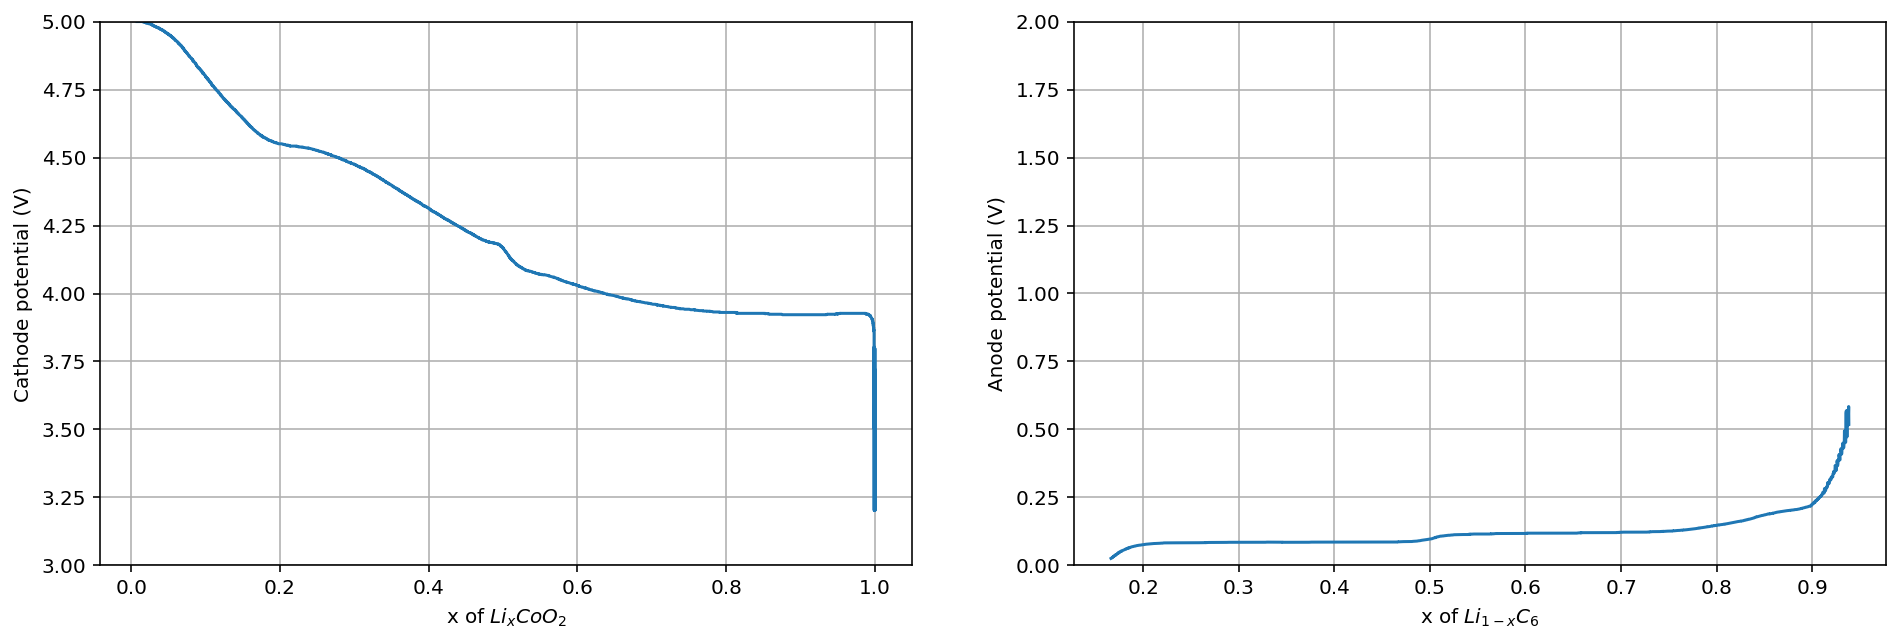

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(df_LCO_OCV['x'], df_LCO_OCV['Potential(V)'])
ax1.set_ylim([3, 5])
ax1.set_ylabel('Cathode potential (V)')
ax1.set_xlabel('x of $Li_{x}CoO_2$')
ax1.grid()

ax2.plot(df_LiC6_OCV['x'], df_LiC6_OCV['Potential(V)'])
ax2.set_ylim([0, 2])
ax2.set_ylabel('Anode potential (V)')
ax2.set_xlabel('x of $Li_{1-x}C_6$')
ax2.grid()
plt.show()

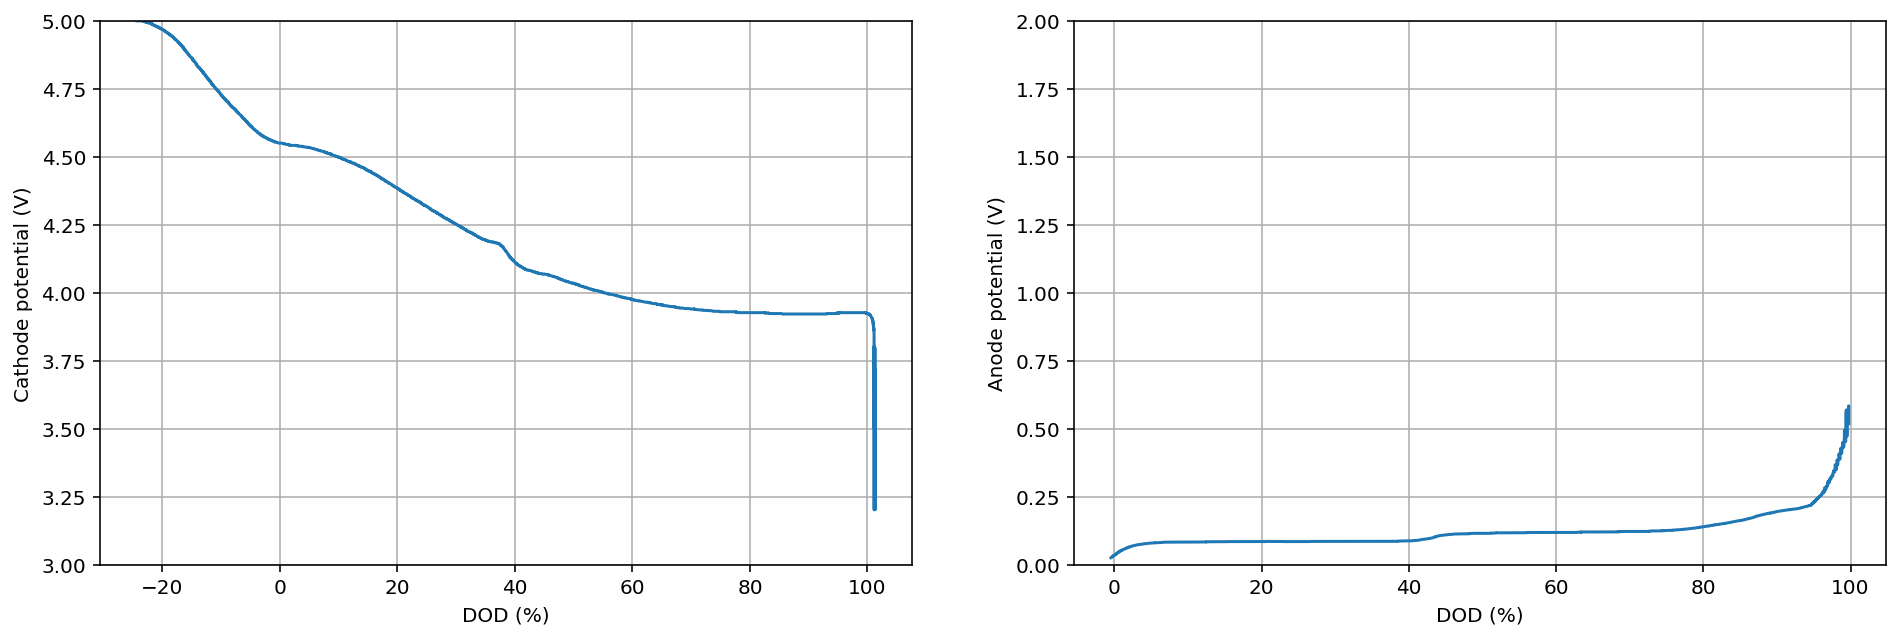

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(df_LCO_OCV['DOD'], df_LCO_OCV['Potential(V)'])
ax1.set_ylim([3, 5])
ax1.set_ylabel('Cathode potential (V)')
ax1.set_xlabel('DOD (%)')
ax1.grid()

ax2.plot(df_LiC6_OCV['DOD'], df_LiC6_OCV['Potential(V)'])
ax2.set_ylim([0, 2])
ax2.set_ylabel('Anode potential (V)')
ax2.set_xlabel('DOD (%)')
ax2.grid()
plt.show()

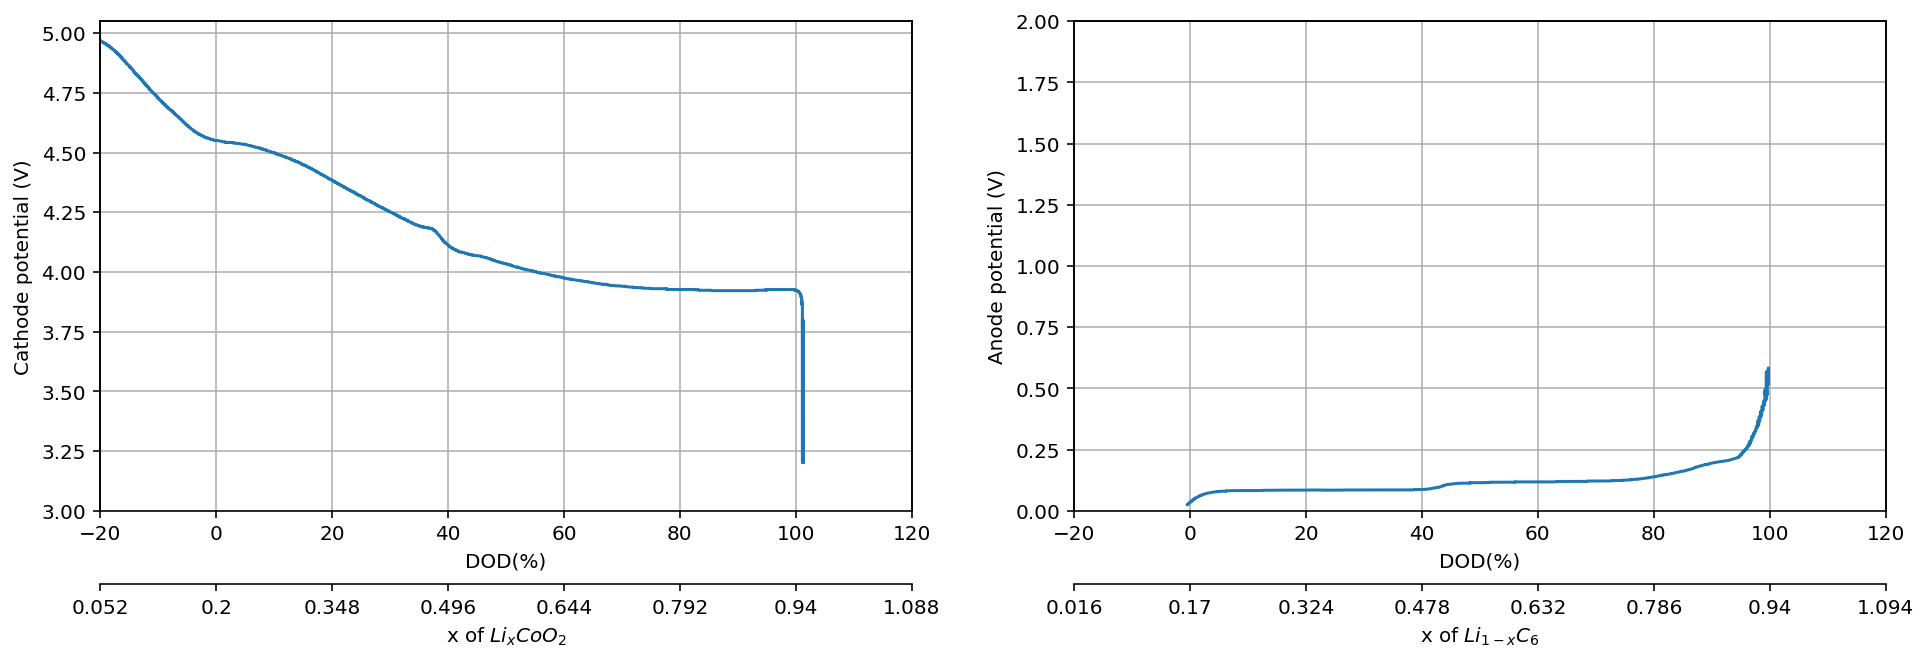

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

fig.subplots_adjust(bottom=0.2)
ax1.plot(df_LCO_OCV['DOD'], df_LCO_OCV['Potential(V)'])
ax1.set_ylim([3, 5.05])
ax1.set_xlim([-20,120])
ax1.set_ylabel('Cathode potential (V)')
ax1.set_xlabel('DOD(%)')
ax1.grid()

ax3 = ax1.twiny()
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
ax3.spines["bottom"].set_position(("axes", -0.15))

ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.spines["bottom"].set_visible(True)
ax3.set_xticks([-20,0,20,40,60,80,100,120])
ax3.set_xticklabels(re_DOD_norm2(np.array([-20,0,20,40,60,80,100,120]), x_p_s, x_n_e))
ax3.set_xlabel("x of $Li_{x}CoO_2$")


ax2.plot(df_LiC6_OCV['DOD'], df_LiC6_OCV['Potential(V)'])
ax2.set_ylim([0, 2])
ax2.set_xlim([-20,120])
ax2.set_ylabel('Anode potential (V)')
ax2.set_xlabel('DOD(%)')
ax2.grid()

ax4 = ax2.twiny()
ax4.xaxis.set_ticks_position("bottom")
ax4.xaxis.set_label_position("bottom")
ax4.spines["bottom"].set_position(("axes", -0.15))
ax4.set_frame_on(True)
ax4.patch.set_visible(False)
ax4.spines["bottom"].set_visible(True)
ax4.set_xticks([-20,0,20,40,60,80,100,120])
ax4.set_xticklabels(re_DOD_norm2(np.array([-20,0,20,40,60,80,100,120]), x_n_s, x_n_e))
ax4.set_xlabel("x of $Li_{1-x}C_6$")



plt.show()

In [15]:
df_cell = pd.DataFrame(np.arange(1001))/10
df_cell.columns = ['DOD']
df_cell = pd.merge_asof(df_cell, df_LCO_OCV, on='DOD', direction='nearest')
df_cell = pd.merge_asof(df_cell, df_LiC6_OCV, on='DOD', direction='nearest')
df_cell.columns = ['DOD', 'Cathode x (-)', 'Cathode OCV (V)', 'Anode x (-)', 'Anode OCV (V)']
df_cell['Cell OCV (V)'] = (df_cell['Cathode OCV (V)']  - df_cell['Anode OCV (V)'] )
df_cell

,DOD,Cathode x (-),Cathode OCV (V),Anode x (-),Anode OCV (V),Cell OCV (V)
0,0.0,0.20032,4.55072,0.169631,0.034329,4.516391
1,0.1,0.20040,4.55072,0.170686,0.036918,4.513802
2,0.2,0.20132,4.55072,0.171753,0.039765,4.510955
3,0.3,0.20241,4.55072,0.172365,0.039610,4.511110
4,0.4,0.20341,4.54988,0.173068,0.042250,4.507630
...,...,...,...,...,...,...
996,99.6,0.98697,3.92698,0.936868,0.515807,3.411173
997,99.7,0.98797,3.92656,0.937583,0.515807,3.410753
998,99.8,0.98797,3.92656,0.938267,0.518913,3.407647
999,99.9,0.98897,3.92447,0.938267,0.518913,3.405557


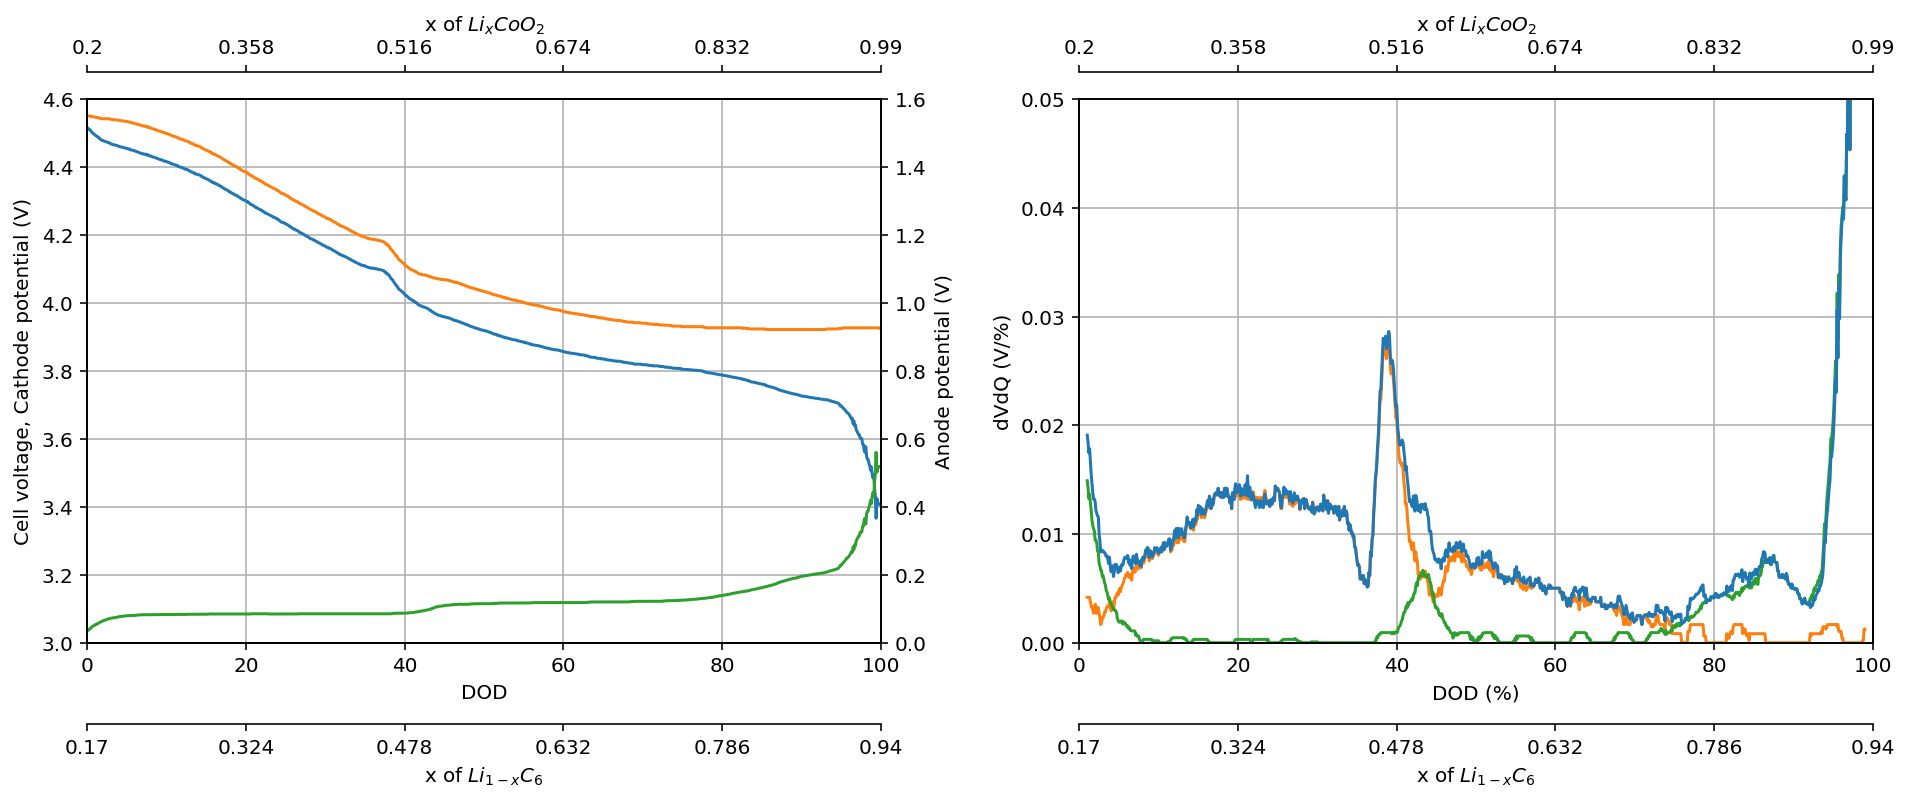

In [16]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.25)
ax2 = ax1.twinx()
ax1.plot(df_cell['DOD'], df_cell['Cathode OCV (V)'], color = new_colors[1])
ax1.plot(df_cell['DOD'], df_cell['Cell OCV (V)'], color = new_colors[0])
ax1.set_ylabel('Cell voltage, Cathode potential (V)')
ax2.plot(df_cell['DOD'], df_cell['Anode OCV (V)'], color = new_colors[2])
ax2.set_ylabel('Anode potential (V)')
ax1.set_xlabel('DOD')

ax1.set_ylim([3, 4.6])
ax2.set_ylim([0, 1.6])
ax1.grid()

ax1.set_xlim([0,100])
ax4 = ax1.twiny()
ax4.xaxis.set_ticks_position("bottom")
ax4.xaxis.set_label_position("bottom")
ax4.spines["bottom"].set_position(("axes", -0.15))

ax4.set_frame_on(True)
ax4.patch.set_visible(False)
ax4.spines["bottom"].set_visible(True)
ax4.set_xticks([0,20,40,60,80,100])
ax4.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_n_s, x_n_e))
ax4.set_xlabel("x of $Li_{1-x}C_6$")


ax5 = ax1.twiny()
ax5.xaxis.set_ticks_position("top")
ax5.xaxis.set_label_position("top")
ax5.spines["top"].set_position(("axes", +1.05))

ax5.set_frame_on(True)
ax5.patch.set_visible(False)
ax5.spines["top"].set_visible(True)
ax5.set_xticks([0,20,40,60,80,100])
ax5.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_p_s, x_p_e))
ax5.set_xlabel("x of $Li_{x}CoO_2$")



ax3.plot(df_cell['DOD'], dQdV(df_cell['DOD'], df_cell['Cathode OCV (V)'], 10), color = new_colors[1])
ax3.plot(df_cell['DOD'], dQdV(df_cell['DOD'], df_cell['Anode OCV (V)'], 10), color = new_colors[2])
ax3.plot(df_cell['DOD'], dQdV(df_cell['DOD'], df_cell['Cell OCV (V)'], 10), color = new_colors[0])


ax3.set_ylabel('dVdQ (V/%)')
ax3.set_xlabel('DOD (%)')

ax3.set_ylim([0, 0.05])
ax3.grid(which='both')

ax3.set_xlim([0,100])
ax6 = ax3.twiny()
ax6.xaxis.set_ticks_position("bottom")
ax6.xaxis.set_label_position("bottom")
ax6.spines["bottom"].set_position(("axes", -0.15))

ax6.set_frame_on(True)
ax6.patch.set_visible(False)
ax6.spines["bottom"].set_visible(True)
ax6.set_xticks([0,20,40,60,80,100])
ax6.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_n_s, x_n_e))
ax6.set_xlabel("x of $Li_{1-x}C_6$")


ax7 = ax3.twiny()
ax7.xaxis.set_ticks_position("top")
ax7.xaxis.set_label_position("top")
ax7.spines["top"].set_position(("axes", +1.05))

ax7.set_frame_on(True)
ax7.patch.set_visible(False)
ax7.spines["top"].set_visible(True)
ax7.set_xticks([0,20,40,60,80,100])
ax7.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_p_s, x_p_e))
ax7.set_xlabel("x of $Li_{x}CoO_2$")


plt.show()


## Diffuion in solid phase

Fick'S second law
\begin{eqnarray*}
\frac{\partial C_s(x,t)}{\partial t} = D_s\frac{\partial^2 C_s(x,t)}{\partial x^2}
\end{eqnarray*}
Boundary condition and initial condition
\begin{eqnarray*}
\frac{\partial C_s(x=0,t)}{\partial t} = 0\\
\frac{\partial C_s(x=R_s,t)}{\partial t} = j(t)\\
C_s(x,t=0)=C_{s,0}
\end{eqnarray*}

In [261]:
#Temperature
T = 298#[K]
temp_0 = 23 + 273.15#[K]


#Constant
R = 8.3144598 #[J/(mol K)]
F = 96485.33289 #[C/mol]
z = 1
alpha=0.5

k_o_p = 2.344E-11#7.13E-8
k_o_n = 5.0307E-11#1.47E-7
C_e_0 = 1000#[mol/m3]
C_s_max_p = 2.39E4 #[mol/m3]
C_s_max_n = 1.61E4 #[mol/m3]
C_s_p_0 = C_s_max_p*df_cell['Cathode x (-)'][0]
C_s_n_0 = C_s_max_n*(1 - df_cell['Anode x (-)'][0])

epsilon_e = 0.724
brugg_e = 4

#Area Dimension
M = 100E-6 #[m]
N = 100E-6 #[m]
S = M * N#[m2]

#Cathode Dimension
L1 = 100E-6 #[m]
L2 = 200E-6 #[m]
Al_length = L1
P_length = L2-L1

#Electrolyte Dimension
L3 = 300E-6 #[m]
El_length = (L3*1E6-L2*1E6)/1E6 #[m]

#Anode Dimension
N_length = ((max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*S*P_length*F)/((max(df_cell['Anode x (-)']) - min(df_cell['Anode x (-)']))*C_s_max_n*S*F)
Cu_length = 100E-6 #[m]
L4 = L3 + N_length #[m]
L5 = L4 + Cu_length #[m]

#Current
I = 6.4E-7#[A = C/sec]
j = I/S*0.05#(0.1ItA)[A/m2 = C/sec m2]

# Charge or Discharge
Condition = 'Discharge'
if Condition == 'Charge':
    j = abs(j)*(-1)

#Diffusion coefficient
D_p = 1.0E-12 #[m2/s]
D_n = 2.0E-12 #[m2/s]



In [86]:
j

3.2

In [87]:
N_length

0.00015250553881129882

In [88]:
# Memo
# C = C/sec sec = A sec
# C*60*60 = Ah

In [89]:
# Cathode capacity
print((max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*S*P_length*F) # [C]
print((max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*S*P_length*F/3600) # [C/sec * sec /36000 = A sec /36000 =Ah ]
Full_cap = (max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*S*P_length*F/3600 #Ah

0.00182093247049
5.05814575135e-07


In [90]:
# Anode capacity
print((max(df_cell['Anode x (-)']) - min(df_cell['Anode x (-)']))*C_s_max_n*S*N_length*F) # [C]
print((max(df_cell['Anode x (-)']) - min(df_cell['Anode x (-)']))*C_s_max_n*S*N_length*F/3600) # [C/sec * sec /36000 = A sec /36000 =Ah ]

0.00182093247049
5.05814575135e-07


In [91]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 10
dx = P_length/n

t_total = 60*60*20 #[sec] run time
dt = 0.05 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, P_length - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_s_p_0*S
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros((len(t)+1))
x_rlt = np.zeros((len(t)+1,len(x)))
C_rlt = np.zeros((len(t)+1,len(C)))
x_rlt[0] = x
C_rlt[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = D_p*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = D_p*((C[1] - C[0])/dx)/dx
    dCdt[n-1] = D_p*(j*S/F/D_p - (C[n-1] - C[n-2])/dx)/dx
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj] = (jj)*dt
    x_rlt[jj] = x #
    C_rlt[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
1.7e+01 sec


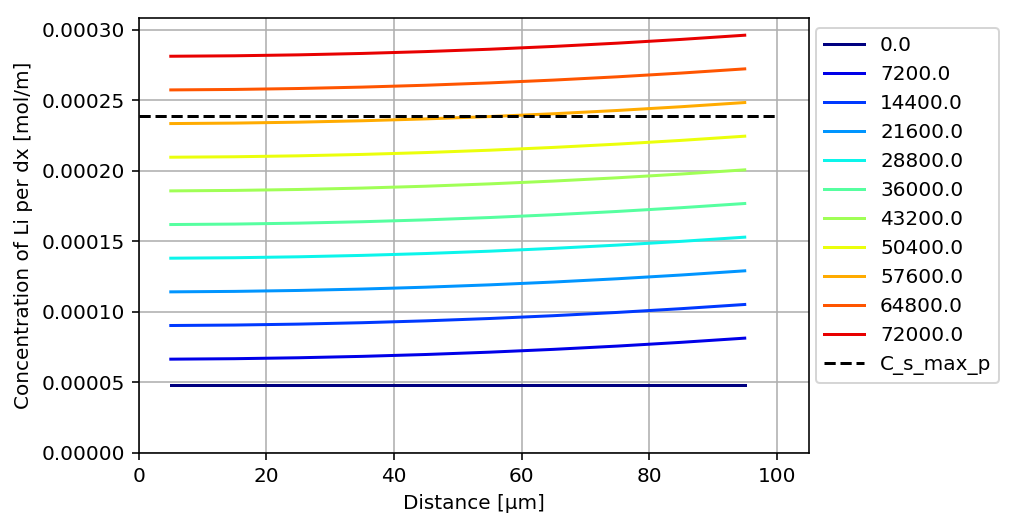

In [92]:
tt=(t_total-dt)/10#[sec] delta time for plot
for ii in range(len(time_rlt[time_rlt % tt == 0])):
    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
plt.plot(([0,100]),([C_s_max_p*S,C_s_max_p*S]),'--',label='C_s_max_p',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)#.xlim(0,100)
plt.grid()
plt.show()

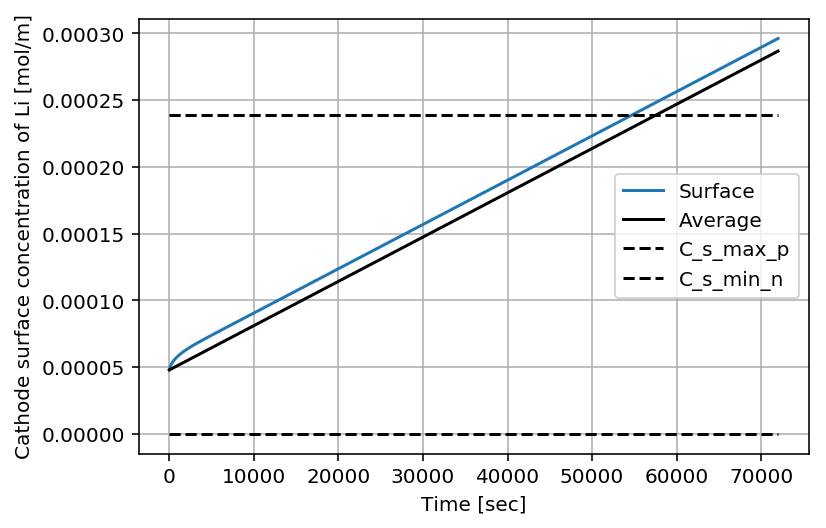

In [93]:
plt.plot(time_rlt,C_rlt[:,-1], label='Surface')
plt.plot(([0,t_total]), ([sum(C_rlt[0,:])/n, sum(C_rlt[-1,:])/n]), color = 'black', label='Average')
plt.plot(([0,t_total]),([C_s_max_p*S,C_s_max_p*S]),'--',label='C_s_max_p',color='black')
plt.plot(([0,t_total]),([0, 0]),'--',label='C_s_min_n',color='black')
plt.ylabel('Cathode surface concentration of Li [mol/m]')
plt.xlabel('Time [sec]')
plt.legend()
plt.grid()
plt.show()

In [94]:
# Convert concentration to x stoichiometric ratio of cathode.
slr_p = LinearRegression()
X_p = np.array([sum(C_rlt[0,:])/n/S, 0])
y_p = np.array([min(df_cell['Cathode x (-)']), 0])
X_p = X_p.reshape(-1, 1)
y_p = y_p.reshape(-1, 1)
slr_p.fit(X_p, y_p)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [95]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 16
dx = N_length/n

t_total = 60*60*20 #[sec] run time
dt = 0.05 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, N_length - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_s_n_0*S
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt_n = np.zeros(len(t)+1)
x_rlt_n = np.zeros((len(t)+1,len(x)))
C_rlt_n = np.zeros((len(t)+1,len(C)))

x_rlt_n[0] = x
C_rlt_n[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = D_n*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = D_n*((C[1] - C[0])/dx)/dx
    dCdt[n-1] = D_n*(-j*S/F/D_n - (C[n-1] - C[n-2])/dx)/dx
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt_n[jj] = (jj)*dt
    x_rlt_n[jj] = x #
    C_rlt_n[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
2.6e+01 sec


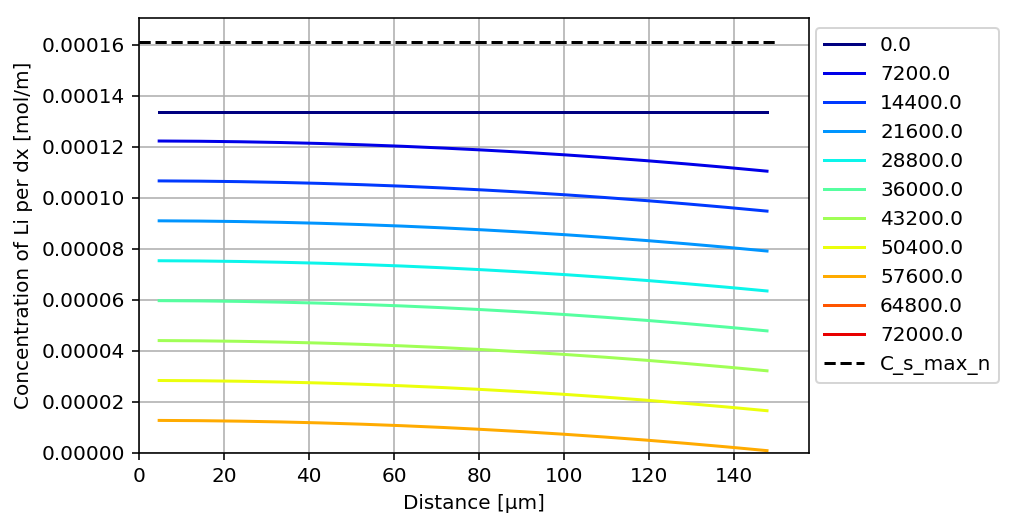

In [96]:
tt=(t_total-dt)/10#[sec] delta time for plot
for ii in range(len(time_rlt_n[time_rlt_n % tt == 0])):
    plt.plot(x_rlt_n[time_rlt_n % tt == 0][ii]*1E6,C_rlt_n[time_rlt_n % tt == 0][ii], label = time_rlt_n[time_rlt_n % tt == 0][ii],color=cm.jet(ii/len(time_rlt_n[time_rlt_n % tt == 0])))
plt.plot(([0,150]),([C_s_max_n*S,C_s_max_n*S]),'--',label='C_s_max_n',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)
plt.grid()
plt.show()

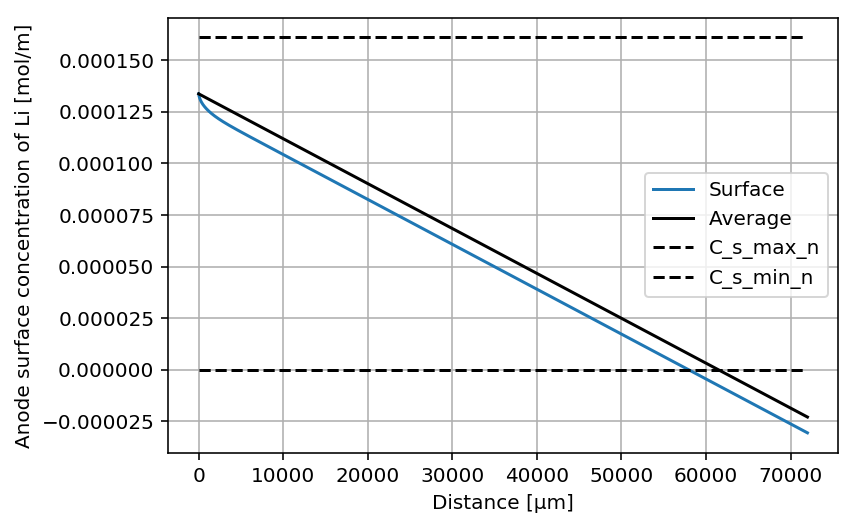

In [97]:
plt.plot(time_rlt_n,C_rlt_n[:,-1], label='Surface')
plt.plot(([0,t_total]), ([sum(C_rlt_n[0,:])/n, sum(C_rlt_n[-1,:])/n]), color = 'black', label='Average')
plt.plot(([0,t_total]),([C_s_max_n*S,C_s_max_n*S]),'--',label='C_s_max_n',color='black')
plt.plot(([0,t_total]),([0, 0]),'--',label='C_s_min_n',color='black')
plt.ylabel('Anode surface concentration of Li [mol/m]')
plt.xlabel('Distance [μm]')
plt.legend()
plt.grid()
plt.show()

In [98]:
# Convert concentration to x stoichiometric ratio of anode.
slr_n = LinearRegression()
X_n = np.array([sum(C_rlt_n[0,:])/n/S, 0])
y_n = np.array([min(df_cell['Anode x (-)']), 1])
X_n = X_n.reshape(-1, 1)
y_n = y_n.reshape(-1, 1)
slr_n.fit(X_n, y_n)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [99]:
df_sim = pd.DataFrame(time_rlt)
df_sim.columns = ['Time (sec)']
df_sim['C_s_p_surface (mol/m3)'] = C_rlt[:,-1]/S # Li concentration at the surface of positive electrode material
df_sim['C_s_n_surface (mol/m3)'] = C_rlt_n[:,-1]/S # Li concentration at the surface of positive electrode material

df_sim['Cathode x of surface (-)'] = slr_p.predict(np.array(df_sim['C_s_p_surface (mol/m3)']).reshape(-1, 1))
df_sim['Anode x of surface (-)'] = slr_n.predict(np.array(df_sim['C_s_n_surface (mol/m3)']).reshape(-1, 1))
df_sim['Current density (A/m2)'] = j
df_sim['Capacity (Ah)'] = df_sim['Time (sec)'] * df_sim['Current density (A/m2)']*S/(60*60)

df_sim['DOD'] = df_sim['Capacity (Ah)']/Full_cap*100
df_sim = pd.merge_asof(df_sim, df_LCO_OCV, on='DOD', direction='nearest')
df_sim = pd.merge_asof(df_sim, df_LiC6_OCV, on='DOD', direction='nearest')
df_sim.columns = ['Time (sec)', 'C_s_p_surface (mol/m3)', 'C_s_n_surface (mol/m3)','Cathode x of surface (-)','Anode x of surface (-)', 'Current density (A/m2)', 'Capacity (Ah)', 'DOD (%)', 'Cathode x (-)', 'Cathode OCV (V)', 'Anode x (-)', 'Anode OCV (V)']
df_sim['Cell OCV (V)'] = (df_sim['Cathode OCV (V)']  - df_sim['Anode OCV (V)'])

df_tmp = df_LCO_OCV[['x', 'Potential(V)']]
df_tmp.columns = ['Cathode x of surface (-)','Cathode surface OCV (V)']
df_sim = pd.merge_asof(df_sim, df_tmp, on='Cathode x of surface (-)', direction='nearest')
df_tmp = df_LiC6_OCV[['x', 'Potential(V)']]
df_tmp.columns = ['Anode x of surface (-)','Anode surface OCV (V)']
df_sim = pd.merge_asof(df_sim.sort_values('Anode x of surface (-)') , df_tmp, on='Anode x of surface (-)', direction='nearest')
df_sim = df_sim.sort_values('Time (sec)').reset_index(drop=True)
df_sim = df_sim[df_sim['C_s_p_surface (mol/m3)'] <= C_s_max_p]
df_sim = df_sim[df_sim['Anode x of surface (-)'] <= max(df_LiC6_OCV['x'])]
df_sim


,Time (sec),C_s_p_surface (mol/m3),C_s_n_surface (mol/m3),Cathode x of surface (-),Anode x of surface (-),Current density (A/m2),Capacity (Ah),DOD (%),Cathode x (-),Cathode OCV (V),Anode x (-),Anode OCV (V),Cell OCV (V),Cathode surface OCV (V),Anode surface OCV (V)
0,0.00,4787.648000,13368.948882,0.200320,0.169631,3.2,0.000000e+00,0.000000,0.20032,4.55072,0.169631,0.034329,4.516391,4.55072,0.034329
1,0.05,4787.813828,13368.774905,0.200327,0.169641,3.2,4.444444e-13,0.000088,0.20032,4.55072,0.169631,0.034329,4.516391,4.55072,0.034329
2,0.10,4787.979574,13368.601119,0.200334,0.169652,3.2,8.888889e-13,0.000176,0.20032,4.55072,0.169631,0.034329,4.516391,4.55072,0.034329
3,0.15,4788.145236,13368.427524,0.200341,0.169663,3.2,1.333333e-12,0.000264,0.20032,4.55072,0.169631,0.034329,4.516391,4.55072,0.034329
4,0.20,4788.310816,13368.254119,0.200348,0.169674,3.2,1.777778e-12,0.000351,0.20032,4.55072,0.169631,0.034329,4.516391,4.55072,0.034329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067669,53383.45,23437.844316,993.943660,0.980663,0.938264,3.2,4.745196e-07,93.812946,0.94084,3.92363,0.892450,0.212631,3.710999,3.92698,0.520155
1067670,53383.50,23437.860899,993.932786,0.980664,0.938265,3.2,4.745200e-07,93.813034,0.94084,3.92363,0.892450,0.212631,3.710999,3.92698,0.520155
1067671,53383.55,23437.877482,993.921913,0.980664,0.938266,3.2,4.745204e-07,93.813122,0.94084,3.92363,0.892450,0.212631,3.710999,3.92698,0.518913
1067672,53383.60,23437.894064,993.911039,0.980665,0.938266,3.2,4.745209e-07,93.813210,0.94084,3.92363,0.892450,0.212631,3.710999,3.92698,0.518913


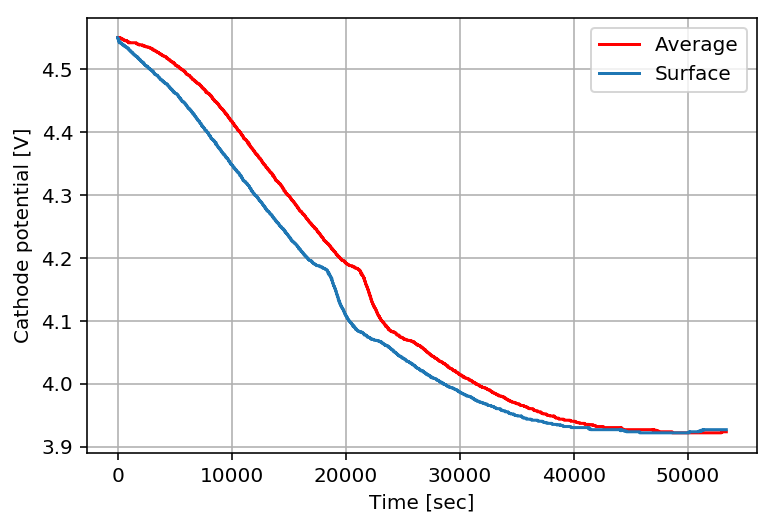

In [100]:
plt.plot(df_sim['Time (sec)'], df_sim['Cathode OCV (V)'], color = 'r', label='Average')
plt.plot(df_sim['Time (sec)'], df_sim['Cathode surface OCV (V)'], label='Surface')
plt.ylabel('Cathode potential [V]')
plt.xlabel('Time [sec]')
plt.legend()
plt.grid()
plt.show()

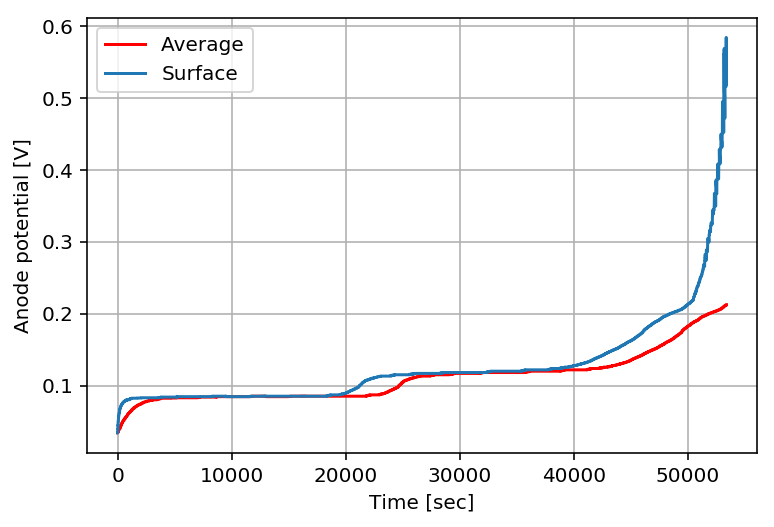

In [101]:
plt.plot(df_sim['Time (sec)'], df_sim['Anode OCV (V)'], color = 'r', label='Average')
plt.plot(df_sim['Time (sec)'], df_sim['Anode surface OCV (V)'], label='Surface')
plt.ylabel('Anode potential [V]')
plt.xlabel('Time [sec]')
plt.legend()
plt.grid()
plt.show()

## Li ion concentration in Liquid phase (Electrolyte)

<img src="NernstPlanck.png" width='400'>

In [34]:
epsilon = 1
Deff = 7.5E-11 #[m2/sec]
t_plus = 0.363

In [35]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 20
dx = El_length/n

t_total = 60*60*20/100 #[sec] run time
dt = 0.005 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, El_length - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_e_0*S
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros((len(t)+1))
x_rlt = np.zeros((len(t)+1,len(x)))
C_rlt = np.zeros((len(t)+1,len(C)))
x_rlt[0] = x
C_rlt[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = 1/epsilon*(Deff*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx)# +　(1-t_plus)/F*j*S)
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx)/dx - 1/P_length*(1-t_plus)/F*j*S)
    dCdt[n-1] = 1/epsilon*(-Deff*((C[n-1] - C[n-2])/dx)/dx + 1/N_length*(1-t_plus)/F*j*S)
    #dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx - j*S/F/Deff)/dx + (1-t_plus)/F*j*S)
    #dCdt[n-1] = 1/epsilon*(Deff*(j*S/F/Deff - (C[n-1] - C[n-2])/dx)/dx + (1-t_plus)/F*j*S)
                                 
    #dCdt[0] = D_n*((C[1] - C[0])/dx)/dx
    #dCdt[n-1] = D_n*(-j*S/F/D_n - (C[n-1] - C[n-2])/dx)/dx
    
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj] = (jj)*dt
    x_rlt[jj] = x #
    C_rlt[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
4.1 sec


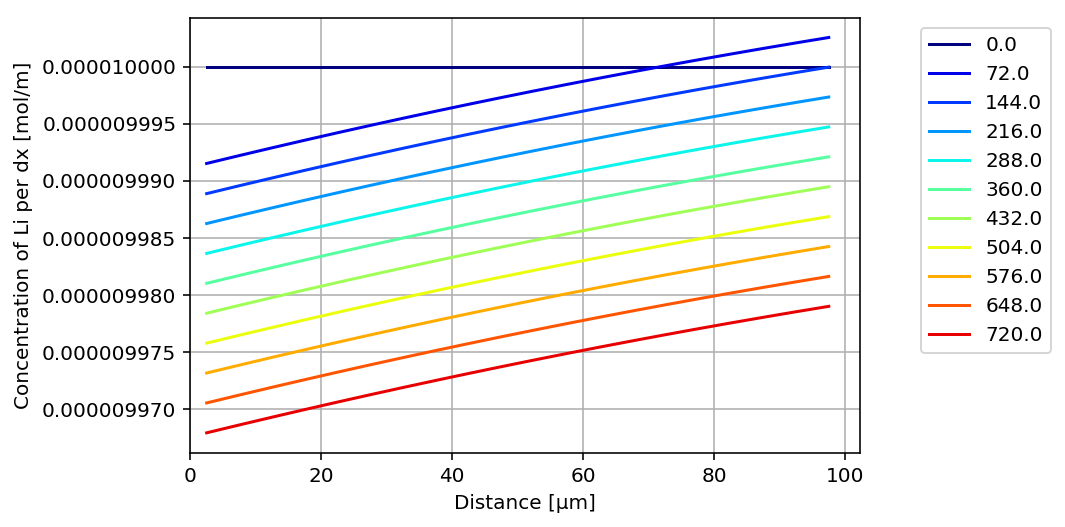

In [36]:
tt=(t_total-dt)/10#[sec] delta time for plot
for ii in range(len(time_rlt[time_rlt % tt == 0])):
    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
#plt.plot(([0,100]),([C_s_max_p*S,C_s_max_p*S]),'--',label='C_s_max_p',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
#plt.gca().set_ylim(bottom=0)#.xlim(0,100)
plt.grid()
plt.show()

In [76]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 20
dx = El_length/n

t_total = 60*60*20/100 #[sec] run time
dt = 0.005 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, El_length - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_e_0*S
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros((len(t)+1))
x_rlt = np.zeros((len(t)+1,len(x)))
C_rlt = np.zeros((len(t)+1,len(C)))
x_rlt[0] = x
C_rlt[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = 1/epsilon*(Deff*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx)# +　(1-t_plus)/F*j*S)
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx)/dx - 1/P_length*(1-t_plus)/F*j*S)
    dCdt[n-1] = 1/epsilon*(-Deff*((C[n-1] - C[n-2])/dx)/dx + 1/N_length*(1-t_plus)/F*j*S)
    #dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx - j*S/F/Deff)/dx + (1-t_plus)/F*j*S)
    #dCdt[n-1] = 1/epsilon*(Deff*(j*S/F/Deff - (C[n-1] - C[n-2])/dx)/dx + (1-t_plus)/F*j*S)
                                 
    #dCdt[0] = D_n*((C[1] - C[0])/dx)/dx
    #dCdt[n-1] = D_n*(-j*S/F/D_n - (C[n-1] - C[n-2])/dx)/dx
    
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj] = (jj)*dt
    x_rlt[jj] = x #
    C_rlt[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
3.6 sec


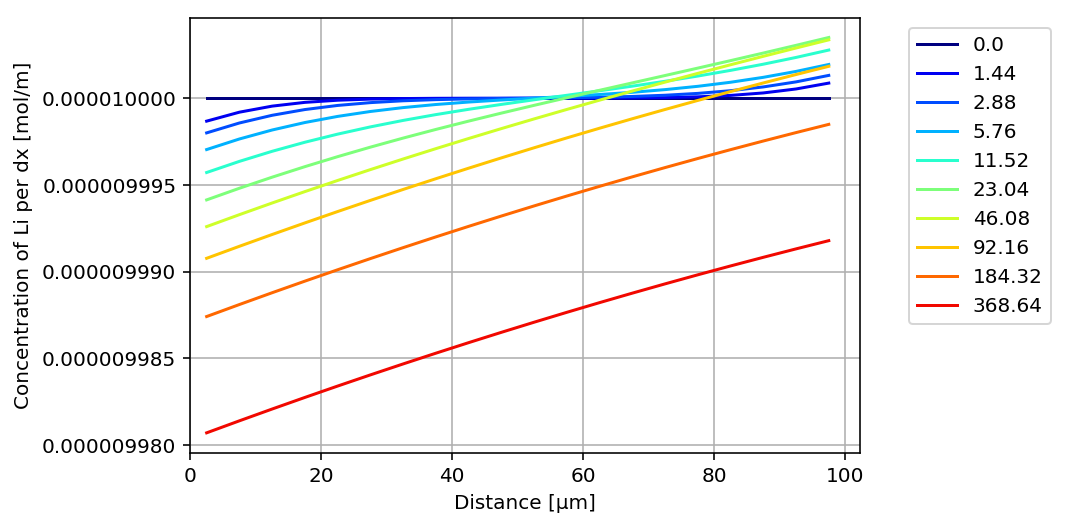

In [79]:
tt=(t_total-dt)/500#[sec] delta time for plot
for ii in range(len(time_rlt[time_rlt % tt == 0])):
    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
#plt.plot(([0,100]),([C_s_max_p*S,C_s_max_p*S]),'--',label='C_s_max_p',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
#plt.gca().set_ylim(bottom=0)#.xlim(0,100)
plt.grid()
plt.show()

If we assume N_length is equal to P_length

In [44]:
#If N_length = P_length

t1 = time.time()
# Number of partitions of rod (finite elements)
n = 20
dx = El_length/n

t_total = 60*60*20/100 #[sec] run time
dt = 0.005 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, El_length - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_e_0*S
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros((len(t)+1))
x_rlt = np.zeros((len(t)+1,len(x)))
C_rlt = np.zeros((len(t)+1,len(C)))
x_rlt[0] = x
C_rlt[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = 1/epsilon*(Deff*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx)# +　(1-t_plus)/F*j*S)
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx)/dx - 1/P_length*(1-t_plus)/F*j*S)
    dCdt[n-1] = 1/epsilon*(-Deff*((C[n-1] - C[n-2])/dx)/dx + 1/P_length*(1-t_plus)/F*j*S)
    #dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx - j*S/F/Deff)/dx + (1-t_plus)/F*j*S)
    #dCdt[n-1] = 1/epsilon*(Deff*(j*S/F/Deff - (C[n-1] - C[n-2])/dx)/dx + (1-t_plus)/F*j*S)
                                 
    #dCdt[0] = D_n*((C[1] - C[0])/dx)/dx
    #dCdt[n-1] = D_n*(-j*S/F/D_n - (C[n-1] - C[n-2])/dx)/dx
    
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj] = (jj)*dt
    x_rlt[jj] = x #
    C_rlt[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
3.9 sec


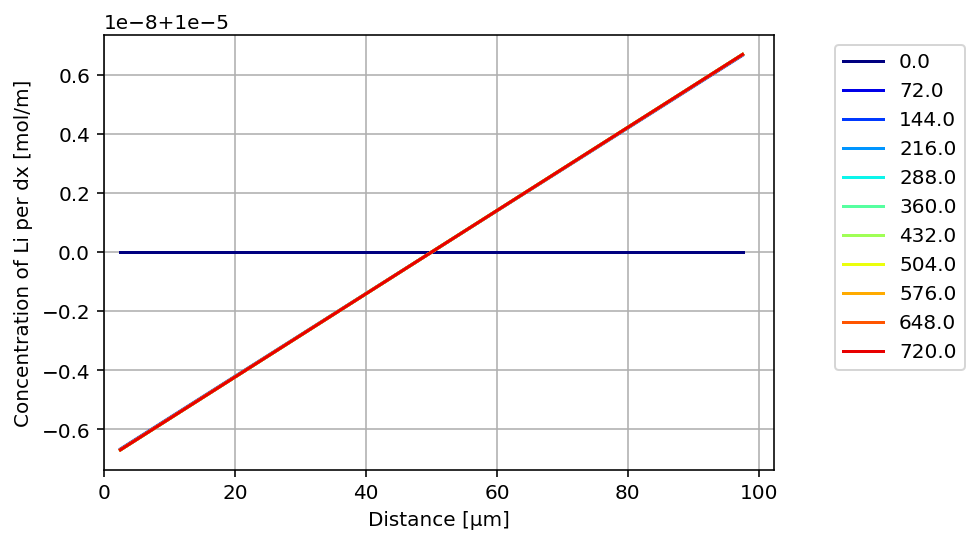

In [45]:
#If N_length = P_length

tt=(t_total-dt)/10#[sec] delta time for plot
for ii in range(len(time_rlt[time_rlt % tt == 0])):
    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
#plt.plot(([0,100]),([C_s_max_p*S,C_s_max_p*S]),'--',label='C_s_max_p',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
#plt.gca().set_ylim(bottom=0)#.xlim(0,100)
plt.grid()
plt.show()

In [48]:
#If N_length = P_length
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 20
dx = El_length/n

t_total = 60*60*20/1000 #[sec] run time
dt = 0.005 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, El_length - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_e_0*S
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros((len(t)+1))
x_rlt = np.zeros((len(t)+1,len(x)))
C_rlt = np.zeros((len(t)+1,len(C)))
x_rlt[0] = x
C_rlt[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = 1/epsilon*(Deff*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx)# +　(1-t_plus)/F*j*S)
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx)/dx - 1/P_length*(1-t_plus)/F*j*S)
    dCdt[n-1] = 1/epsilon*(-Deff*((C[n-1] - C[n-2])/dx)/dx + 1/P_length*(1-t_plus)/F*j*S)
    #dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx - j*S/F/Deff)/dx + (1-t_plus)/F*j*S)
    #dCdt[n-1] = 1/epsilon*(Deff*(j*S/F/Deff - (C[n-1] - C[n-2])/dx)/dx + (1-t_plus)/F*j*S)
                                 
    #dCdt[0] = D_n*((C[1] - C[0])/dx)/dx
    #dCdt[n-1] = D_n*(-j*S/F/D_n - (C[n-1] - C[n-2])/dx)/dx
    
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj] = (jj)*dt
    x_rlt[jj] = x #
    C_rlt[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
0.39 sec


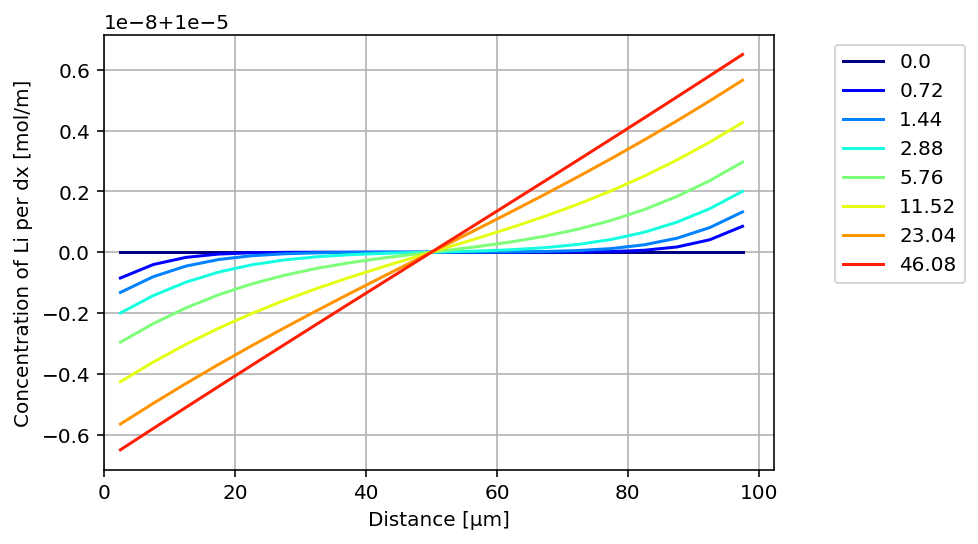

In [49]:
#If N_length = P_length

tt=(t_total-dt)/100#[sec] delta time for plot
for ii in range(len(time_rlt[time_rlt % tt == 0])):
    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
#plt.plot(([0,100]),([C_s_max_p*S,C_s_max_p*S]),'--',label='C_s_max_p',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
#plt.gca().set_ylim(bottom=0)#.xlim(0,100)
plt.grid()
plt.show()

In [102]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 20
dx = El_length/n

t_total = 60*60*20 #[sec] run time
dt = 0.05 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, El_length - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_e_0*S
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros((len(t)+1))
x_rlt = np.zeros((len(t)+1,len(x)))
C_rlt = np.zeros((len(t)+1,len(C)))
x_rlt[0] = x
C_rlt[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = 1/epsilon*(Deff*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx)# +　(1-t_plus)/F*j*S)
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx)/dx - 1/P_length*(1-t_plus)/F*j*S)
    dCdt[n-1] = 1/epsilon*(-Deff*((C[n-1] - C[n-2])/dx)/dx + 1/N_length*(1-t_plus)/F*j*S)
    #dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx - j*S/F/Deff)/dx + (1-t_plus)/F*j*S)
    #dCdt[n-1] = 1/epsilon*(Deff*(j*S/F/Deff - (C[n-1] - C[n-2])/dx)/dx + (1-t_plus)/F*j*S)
                                 
    #dCdt[0] = D_n*((C[1] - C[0])/dx)/dx
    #dCdt[n-1] = D_n*(-j*S/F/D_n - (C[n-1] - C[n-2])/dx)/dx
    
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj] = (jj)*dt
    x_rlt[jj] = x #
    C_rlt[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
3.5e+01 sec


In [401]:
np.array([0,len(time_rlt)])

array([      0, 1440002])

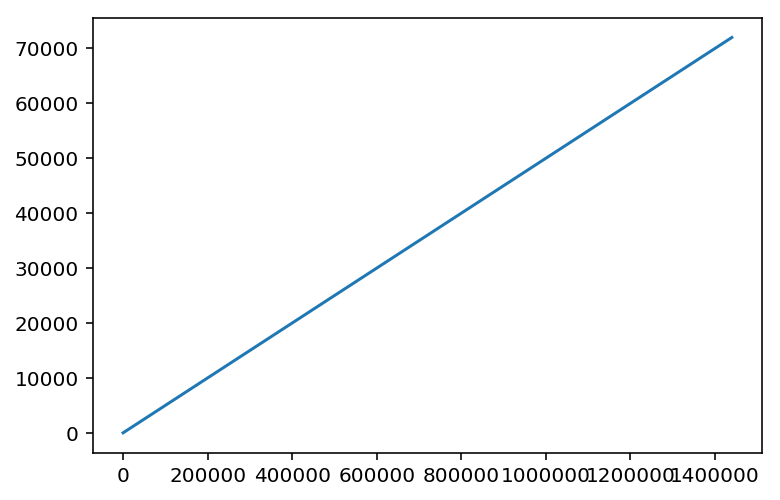

In [403]:
plt.plot(np.array(range(len(time_rlt))),time_rlt)

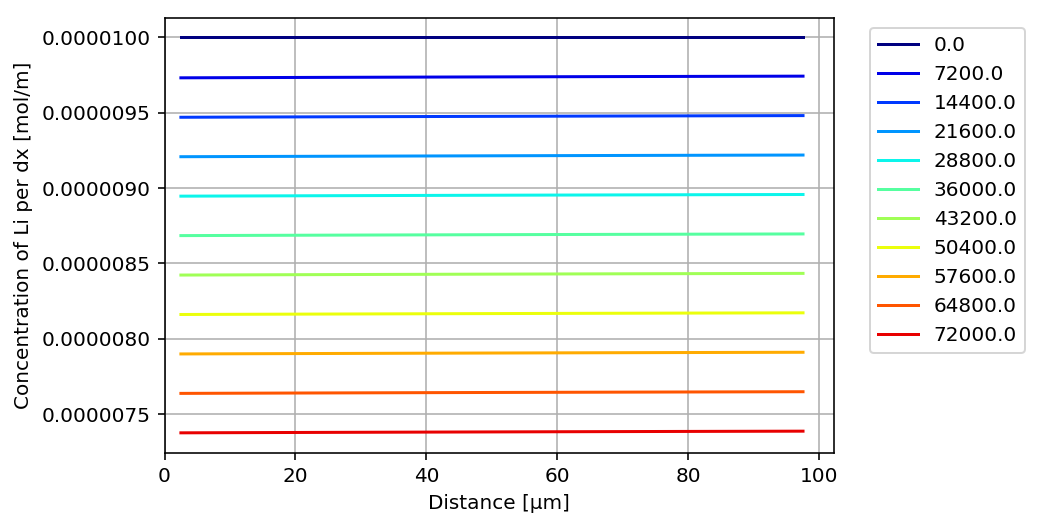

In [103]:
tt=(t_total-dt)/10#[sec] delta time for plot
for ii in range(len(time_rlt[time_rlt % tt == 0])):
    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
#plt.plot(([0,100]),([C_s_max_p*S,C_s_max_p*S]),'--',label='C_s_max_p',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
#plt.gca().set_ylim(bottom=0)#.xlim(0,100)
plt.grid()
plt.show()

In [ ]:
df_sim = pd.DataFrame(time_rlt)
df_sim.columns = ['Time (sec)']
df_sim['C_s_p_surface (mol/m3)'] = C_rlt[:,-1]/S # Li concentration at the surface of positive electrode material
df_sim['C_s_n_surface (mol/m3)'] = C_rlt_n[:,-1]/S # Li concentration at the surface of positive electrode material

df_sim['Cathode x of surface (-)'] = slr_p.predict(np.array(df_sim['C_s_p_surface (mol/m3)']).reshape(-1, 1))
df_sim['Anode x of surface (-)'] = slr_n.predict(np.array(df_sim['C_s_n_surface (mol/m3)']).reshape(-1, 1))
df_sim['Current density (A/m2)'] = j
df_sim['Capacity (Ah)'] = df_sim['Time (sec)'] * df_sim['Current density (A/m2)']*S/(60*60)

df_sim['DOD'] = df_sim['Capacity (Ah)']/Full_cap*100
df_sim = pd.merge_asof(df_sim, df_LCO_OCV, on='DOD', direction='nearest')
df_sim = pd.merge_asof(df_sim, df_LiC6_OCV, on='DOD', direction='nearest')
df_sim.columns = ['Time (sec)', 'C_s_p_surface (mol/m3)', 'C_s_n_surface (mol/m3)','Cathode x of surface (-)','Anode x of surface (-)', 'Current density (A/m2)', 'Capacity (Ah)', 'DOD (%)', 'Cathode x (-)', 'Cathode OCV (V)', 'Anode x (-)', 'Anode OCV (V)']
df_sim['Cell OCV (V)'] = (df_sim['Cathode OCV (V)']  - df_sim['Anode OCV (V)'])

df_tmp = df_LCO_OCV[['x', 'Potential(V)']]
df_tmp.columns = ['Cathode x of surface (-)','Cathode surface OCV (V)']
df_sim = pd.merge_asof(df_sim, df_tmp, on='Cathode x of surface (-)', direction='nearest')
df_tmp = df_LiC6_OCV[['x', 'Potential(V)']]
df_tmp.columns = ['Anode x of surface (-)','Anode surface OCV (V)']
df_sim = pd.merge_asof(df_sim.sort_values('Anode x of surface (-)') , df_tmp, on='Anode x of surface (-)', direction='nearest')
df_sim = df_sim.sort_values('Time (sec)').reset_index(drop=True)
df_sim = df_sim[df_sim['C_s_p_surface (mol/m3)'] <= C_s_max_p]
df_sim = df_sim[df_sim['Anode x of surface (-)'] <= max(df_LiC6_OCV['x'])]
df_sim



In [110]:
np.shape(C_rlt)

(1440002, 20)

In [111]:
np.shape(x_rlt)

(1440002, 20)

In [115]:
np.shape(time_rlt)

(1440002,)

In [116]:
np.shape(C_rlt.reshape(-1))

(28800040,)

In [131]:
np.shape(np.array([time_rlt]*len(C_rlt[0][:])).reshape(-1))

(28800040,)

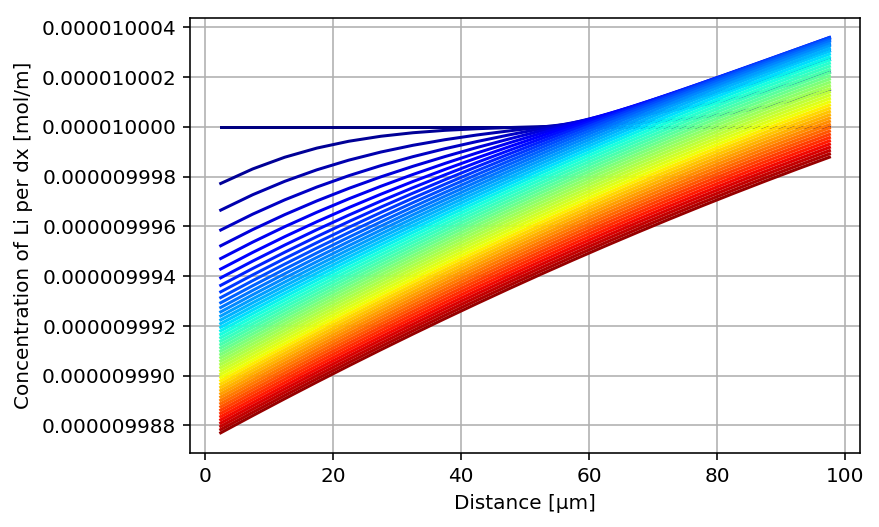

In [474]:
for ii in range(50):
    plt.plot(x_rlt[72*ii][:]*1E6, C_rlt[72*ii][:],color=cm.jet(ii/50), label='Average')
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.grid()
plt.show()

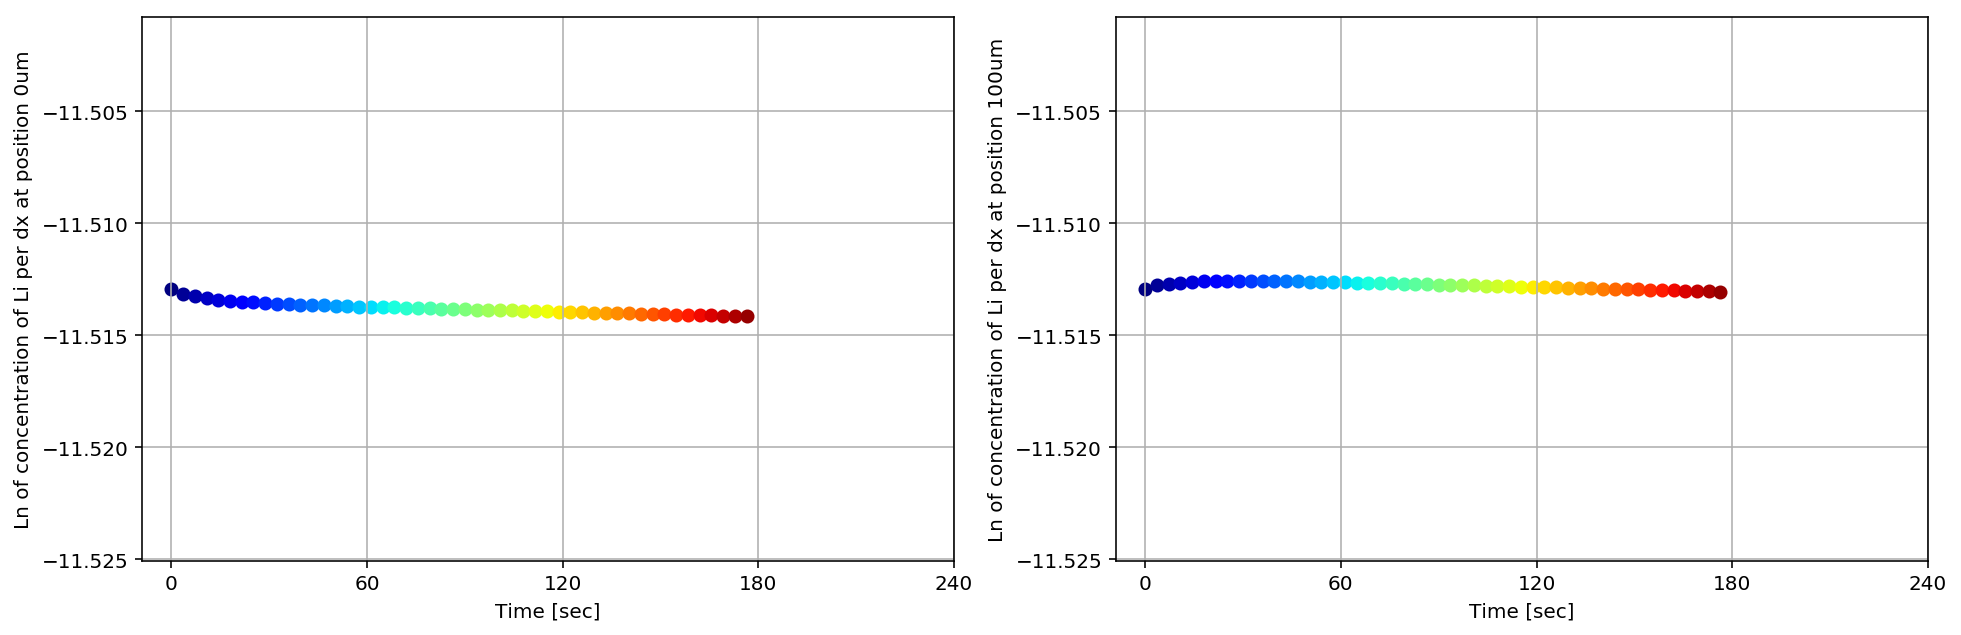

In [443]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))

for ii in range(50):
    ax1.scatter(time_rlt[72*ii], np.log(C_rlt[72*ii][0]),color=cm.jet(ii/50), label='Average')
    ax2.scatter(time_rlt[72*ii], np.log(C_rlt[72*ii][19]),color=cm.jet(ii/50), label='Average')
ax1.grid()
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel('Ln of concentration of Li per dx at position 0um')
ax1.xaxis.set_ticks(np.arange(0, 300, 60))
ax2.grid()
ax2.set_xlabel('Time [sec]')
ax2.set_ylabel('Ln of concentration of Li per dx at position 100um')
ax2.xaxis.set_ticks(np.arange(0, 300, 60))
plt.show()

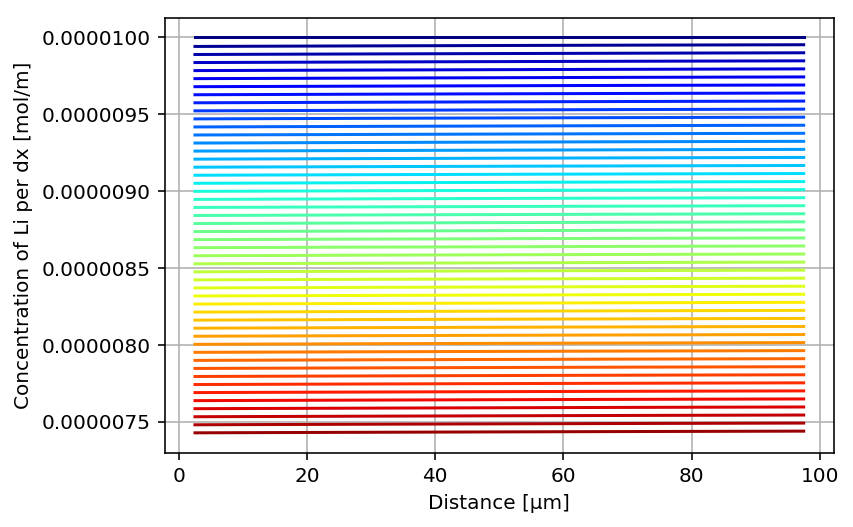

In [475]:
for ii in range(50):
    plt.plot(x_rlt[28800*ii][:]*1e6, C_rlt[28800*ii][:],color=cm.jet(ii/50), label='Average')
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.grid()
plt.show()

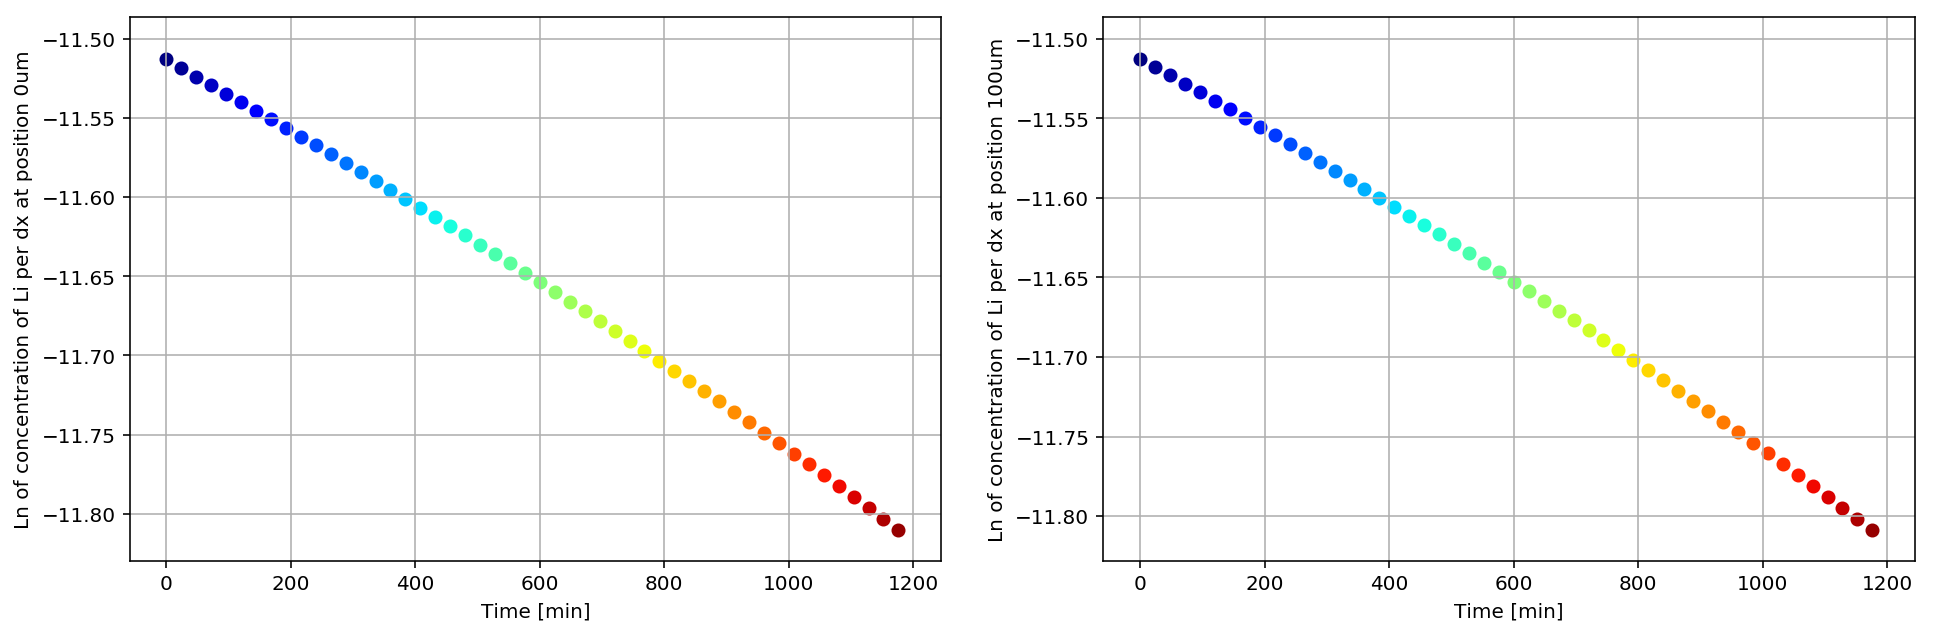

In [455]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))

for ii in range(50):
    ax1.scatter(time_rlt[28800*ii]/60, np.log(C_rlt[28800*ii][0]),color=cm.jet(ii/50), label='Average')
    ax2.scatter(time_rlt[28800*ii]/60, np.log(C_rlt[28800*ii][19]),color=cm.jet(ii/50), label='Average')
ax1.grid()
ax1.set_xlabel('Time [min]')
ax1.set_ylabel('Ln of concentration of Li per dx at position 0um')
#ax1.xaxis.set_ticks(np.arange(0, 1300, 100))
ax2.grid()
ax2.set_xlabel('Time [min]')
ax2.set_ylabel('Ln of concentration of Li per dx at position 100um')
#ax2.xaxis.set_ticks(np.arange(0, 1300, 100))
plt.show()

In [457]:
72000/60

1200.0

## Concentraion overpotential in electrolyte
\begin{eqnarray*}
\frac{2RT}{F}(0.5-t_+)(\ln{c_{e,k}}(x) -\ln{c_{e,k}}(x=0))
\end{eqnarray*}

In [252]:
2*R*T/F*(0.5-t_plus)

0.007036222514395888

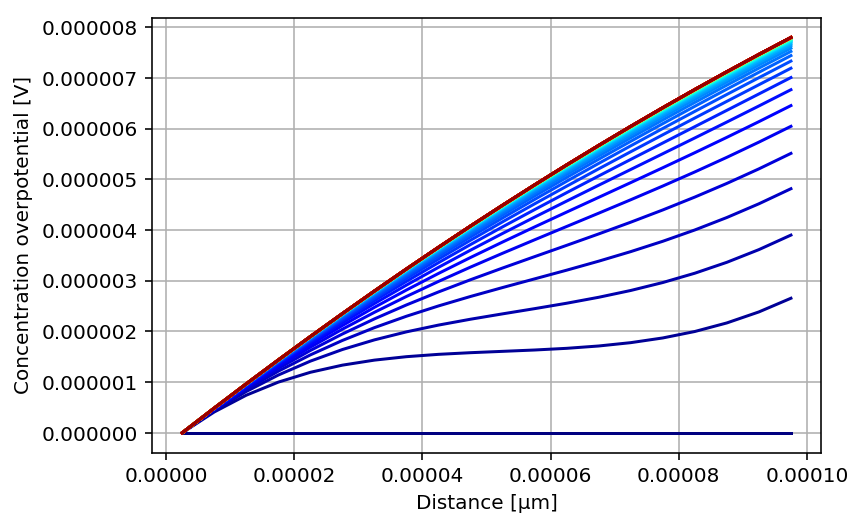

In [461]:
for ii in range(50):
    plt.plot(x_rlt[72*ii][:], 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[72*ii][:])-np.log(C_rlt[72*ii][0])),color=cm.jet(ii/50), label='Average')
plt.ylabel('Concentration overpotential [V]')
plt.xlabel('Distance [μm]')
plt.grid()
plt.show()

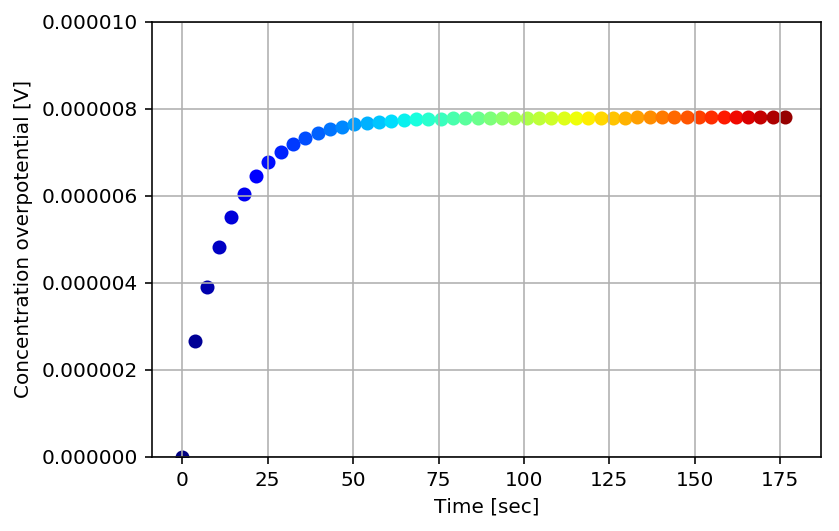

In [471]:
for ii in range(50):
    plt.scatter(time_rlt[72*ii], 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[72*ii][19])-np.log(C_rlt[72*ii][0])),color=cm.jet(ii/50), label='Average')
plt.ylabel('Concentration overpotential [V]')
plt.ylim(0,0.00001)
plt.xlabel('Time [sec]')
plt.grid()
plt.show()

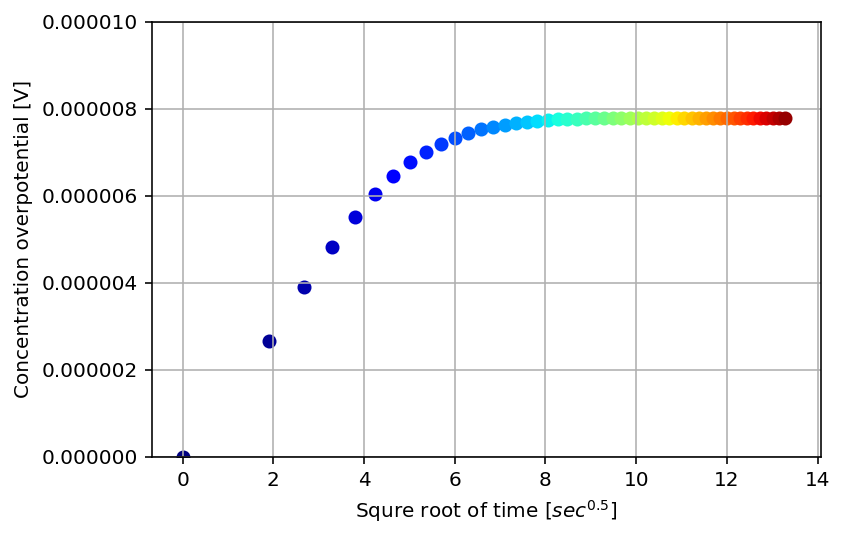

In [479]:
for ii in range(50):
    plt.scatter(np.sqrt(time_rlt[72*ii]), 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[72*ii][19])-np.log(C_rlt[72*ii][0])),color=cm.jet(ii/50), label='Average')
plt.ylabel('Concentration overpotential [V]')
plt.ylim(0,0.00001)
plt.xlabel('Squre root of time [$sec^{0.5}$]')
plt.grid()
plt.show()

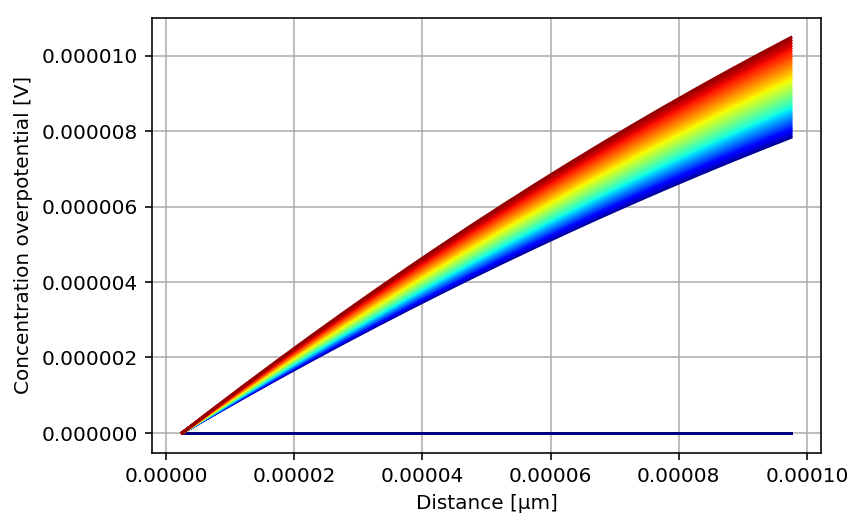

In [462]:
for ii in range(50):
    plt.plot(x_rlt[28800*ii][:], 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[28800*ii][:])-np.log(C_rlt[28800*ii][0])),color=cm.jet(ii/50), label='Average')
plt.ylabel('Concentration overpotential [V]')
plt.xlabel('Distance [μm]')
plt.grid()
plt.show()

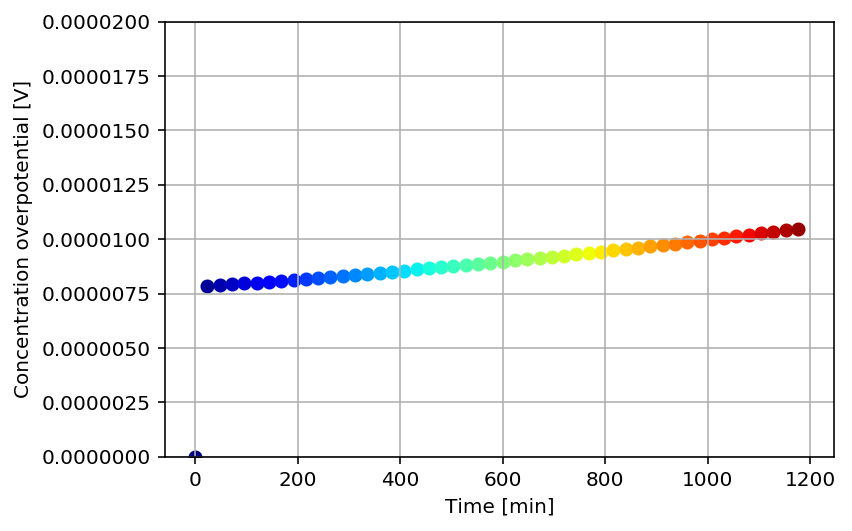

In [476]:
for ii in range(50):
    plt.scatter(time_rlt[28800*ii]/60, 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[28800*ii][19])-np.log(C_rlt[28800*ii][0])),color=cm.jet(ii/50), label='Average')
plt.ylabel('Concentration overpotential [V]')
plt.ylim(0,0.00002)
plt.xlabel('Time [min]')
plt.grid()
plt.show()

## Migration overpotential in electrolyte
\begin{eqnarray*}
\Phi_{e,k}(x,t)=-\frac{x}{\kappa_{eff,k}}\frac{t_+I}{S}
\end{eqnarray*}

\begin{eqnarray*}
\kappa_{eff,k}(x,t)=\epsilon_k^{brugg_k}[4.1253 \times 10^{-2}+5.007 \times 10^{-4}c_{e,k}(x,t)
-4.7212\times10^{-7}c_{e,k}^2(x,t)+1.5094\times10^{-10}c_{e,k}^3(x,t)-1.6018\times10^{-14}c_{e,k}^4(x,t)]
\end{eqnarray*}
unit of $\kappa_{eff,k}$ is [S/m]

In [289]:
#Assume C_e,k as constant (initial concentration C_e_0 = 1000mol/m3)
kappa_e = epsilon_e**brugg_e*(4.1253*1E-2 + 5.007*1E-4*C_e_0 -4.7212*1E-7*C_e_0**2
                              + 1.5094*1E-10*C_e_0**3 - 1.6018*1E-14*C_e_0**4)
kappa_e

0.056258581872730876

In [286]:
#[S/cm]
kappa_e/100

0.0005625858187273087

\begin{eqnarray*}
\kappa=0.0158c_e exp(0.85c_e^{1.4}) [S/cm]
\end{eqnarray*}
[K. Smith, C.-Y. Wang / Journal of Power Sources 161 (2006) 628–639]

In [287]:
0.0158*C_e_0/1000000*np.exp(0.85*(C_e_0/1000000)**1.4)

1.5800847398437009e-05

電気伝導度の値が妥当かどうかは、別途検証する必要あり。

In [291]:
-El_length/kappa_e*t_plus*j

-0.002064751654472542

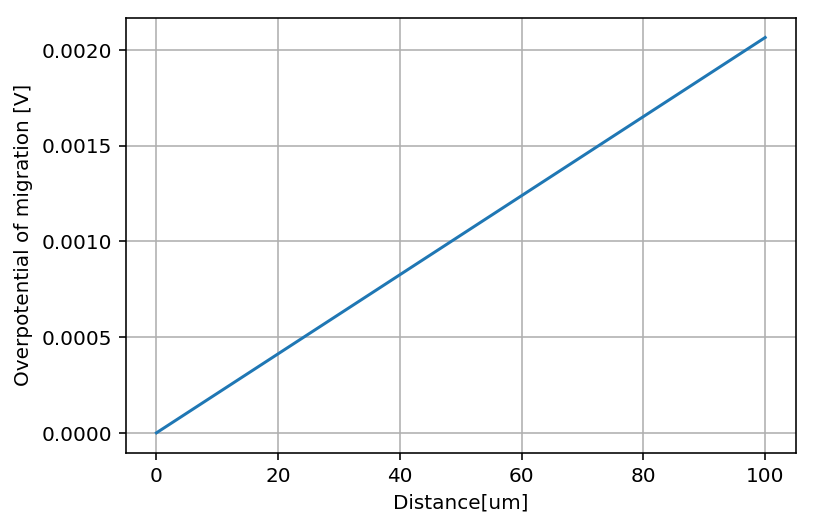

In [481]:
plt.plot([0,El_length*1E6], [0,-El_length/kappa_e*t_plus*(-j)])
plt.xlabel('Distance[um]')
plt.ylabel('Overpotential of migration [V]')
plt.grid()
plt.show()

## Overpotential by foil electronic resistance
\begin{eqnarray*}
\rho(T) = \rho_0[1+\alpha(T-T_0)]
\end{eqnarray*}

In [33]:
#resistivity at 294.15K (20deg.C)
rho_0_Al = 2.82E-8#[ohm m]
rho_0_Cu = 1.68E-8#[ohm m]
alpha_Al = 0.0039#[/K]
alpha_Cu = 0.003862#[/K]

In [34]:
#Overpotential by foil resistance
DV_Al = rho_0_Al * (1 + alpha_Al*(T - temp_0)) * Al_length / S *I
DV_Cu = rho_0_Cu * (1 + alpha_Cu*(T - temp_0)) * Cu_length / S *I
print(DV_Al)
print(DV_Cu)

1.8178216320000008e-10
1.0828819814400002e-10


In [35]:
df_sim['DV_Al'] = rho_0_Al * (1 + alpha_Al*(T - temp_0)) * Al_length / S *I
df_sim['DV_Cu'] = rho_0_Cu * (1 + alpha_Cu*(T - temp_0)) * Cu_length / S *I

## Overpotential by Butler-volmer equation

\begin{eqnarray*}
j = j_0 \left( \exp \left[\frac{\alpha_a zF\eta}{RT}\right] - \exp \left[-\frac{\alpha_c zF\eta}{RT}\right]\right)\\
j_0 = zFk^o(C_e)^{\alpha_a}(C_{s,max}-C_s)^{\alpha_a}(C_s)^{\alpha_c}
\end{eqnarray*}

\begin{eqnarray*}
\eta = \frac{RT}{\alpha zF}ln\left(\frac{j}{2j_0} + \sqrt{\left(\frac{j}{2j_0}\right)^2 + 1} \right)
\end{eqnarray*}

In [35]:
df_sim['j_0_p (A/m2)'] = z*F*k_o_p*C_e**alpha*(C_s_max_p - df_sim['C_s_p_surface (mol/m3)'])**alpha*(df_sim['C_s_p_surface (mol/m3)'])**alpha#[A/m2]
df_sim['j_0_n (A/m2)'] = z*F*k_o_n*C_e**alpha*(C_s_max_n - df_sim['C_s_n_surface (mol/m3)'])**alpha*(df_sim['C_s_n_surface (mol/m3)'])**alpha#[A/m2]
df_sim['DV_eta_p'] = (R*T)/(alpha*z*F)*np.log(df_sim['Current density (A/m2)']/(2*df_sim['j_0_p (A/m2)']) + ((df_sim['Current density (A/m2)']/(2*df_sim['j_0_p (A/m2)']))**2 + 1)**0.5)
df_sim['DV_eta_n'] = (R*T)/(alpha*z*F)*np.log(df_sim['Current density (A/m2)']/(2*df_sim['j_0_n (A/m2)']) + ((df_sim['Current density (A/m2)']/(2*df_sim['j_0_n (A/m2)']))**2 + 1)**0.5)
df_sim['Cathode CCV (V)'] = df_sim['Cathode surface OCV (V)']  - df_sim['DV_Al'] - df_sim['DV_eta_p']
df_sim['Anode CCV (V)'] = df_sim['Anode surface OCV (V)']  + df_sim['DV_Cu'] + df_sim['DV_eta_n']
df_sim['Cell CCV (V)'] = df_sim['Cathode CCV (V)'] - df_sim['Anode CCV (V)']
df_sim = df_sim.dropna()
df_sim

,Time (sec),C_s_p_surface (mol/m3),C_s_n_surface (mol/m3),Cathode x of surface (-),Anode x of surface (-),Current density (A/m2),Capacity (Ah),DOD (%),Cathode x (-),Cathode OCV (V),...,Anode surface OCV (V),DV_Al,DV_Cu,j_0_p (A/m2),j_0_n (A/m2),DV_eta_p,DV_eta_n,Cathode CCV (V),Anode CCV (V),Cell CCV (V)
0,0.0,4787.648000,13368.948882,0.200320,0.169631,3.2,0.000000e+00,0.000000,0.20032,4.55072,...,0.034329,1.817822e-10,1.082882e-10,0.684128,0.927477,0.081436,0.067460,4.469284,0.101789,4.367495
1,0.5,4789.306283,13367.209107,0.200389,0.169739,3.2,4.444444e-12,0.000879,0.20032,4.55072,...,0.034329,1.817822e-10,1.082882e-10,0.684216,0.927712,0.081430,0.067448,4.469290,0.101777,4.367513
2,1.0,4790.956275,13365.488482,0.200458,0.169845,3.2,8.888889e-12,0.001757,0.20032,4.55072,...,0.034329,1.817822e-10,1.082882e-10,0.684305,0.927945,0.081424,0.067437,4.469296,0.101766,4.367530
3,1.5,4792.598058,13363.786585,0.200527,0.169951,3.2,1.333333e-11,0.002636,0.20032,4.55072,...,0.034329,1.817822e-10,1.082882e-10,0.684392,0.928174,0.081418,0.067426,4.469302,0.101755,4.367547
4,2.0,4794.231715,13362.103006,0.200595,0.170056,3.2,1.777778e-11,0.003515,0.20032,4.55072,...,0.034329,1.817822e-10,1.082882e-10,0.684480,0.928401,0.081412,0.067415,4.469308,0.101744,4.367564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106763,53381.5,23437.197585,994.367730,0.980636,0.938238,3.2,4.745022e-07,93.809519,0.94084,3.92363,...,0.530096,1.817822e-10,1.082882e-10,0.235543,0.594885,0.134273,0.088103,3.792707,0.618199,3.174508
106764,53382.0,23437.363414,994.258994,0.980643,0.938245,3.2,4.745067e-07,93.810398,0.94084,3.92363,...,0.527611,1.817822e-10,1.082882e-10,0.235501,0.594854,0.134282,0.088106,3.792698,0.615716,3.176982
106765,53382.5,23437.529242,994.150258,0.980650,0.938252,3.2,4.745111e-07,93.811277,0.94084,3.92363,...,0.525126,1.817822e-10,1.082882e-10,0.235460,0.594824,0.134291,0.088108,3.792689,0.613234,3.179455
106766,53383.0,23437.695070,994.041522,0.980657,0.938258,3.2,4.745156e-07,93.812155,0.94084,3.92363,...,0.522640,1.817822e-10,1.082882e-10,0.235419,0.594793,0.134300,0.088111,3.792680,0.610751,3.181929


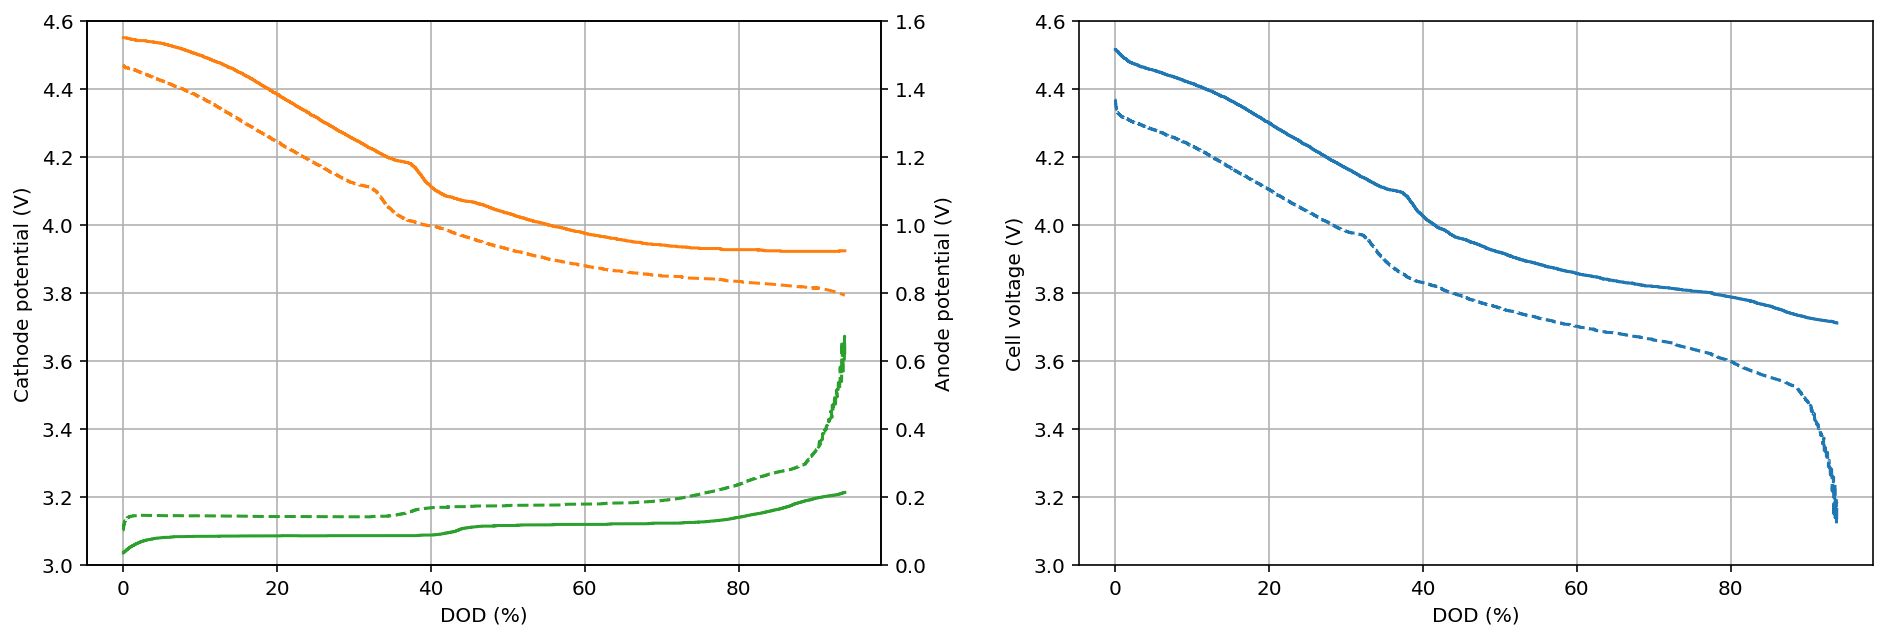

In [36]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.25)
ax2 = ax1.twinx()
ax1.plot(df_sim['DOD (%)'], df_sim['Cathode OCV (V)'], color = new_colors[1])
ax1.plot(df_sim['DOD (%)'], df_sim['Cathode CCV (V)'],'--', color = new_colors[1])
ax1.set_ylabel('Cathode potential (V)')
ax2.plot(df_sim['DOD (%)'], df_sim['Anode OCV (V)'], color = new_colors[2])
ax2.plot(df_sim['DOD (%)'], df_sim['Anode CCV (V)'],'--', color = new_colors[2])
ax2.set_ylabel('Anode potential (V)')
ax1.set_xlabel('DOD (%)')

ax1.set_ylim([3, 4.6])
ax2.set_ylim([0, 1.6])

ax1.grid()

ax3.plot(df_sim['DOD (%)'], df_sim['Cell OCV (V)'], color = new_colors[0])
ax3.plot(df_sim['DOD (%)'], df_sim['Cell CCV (V)'],'--', color = new_colors[0])
ax3.set_ylabel('Cell voltage (V)')
ax3.set_xlabel('DOD (%)')
ax3.set_ylim([3, 4.6])

ax3.grid()

plt.show()

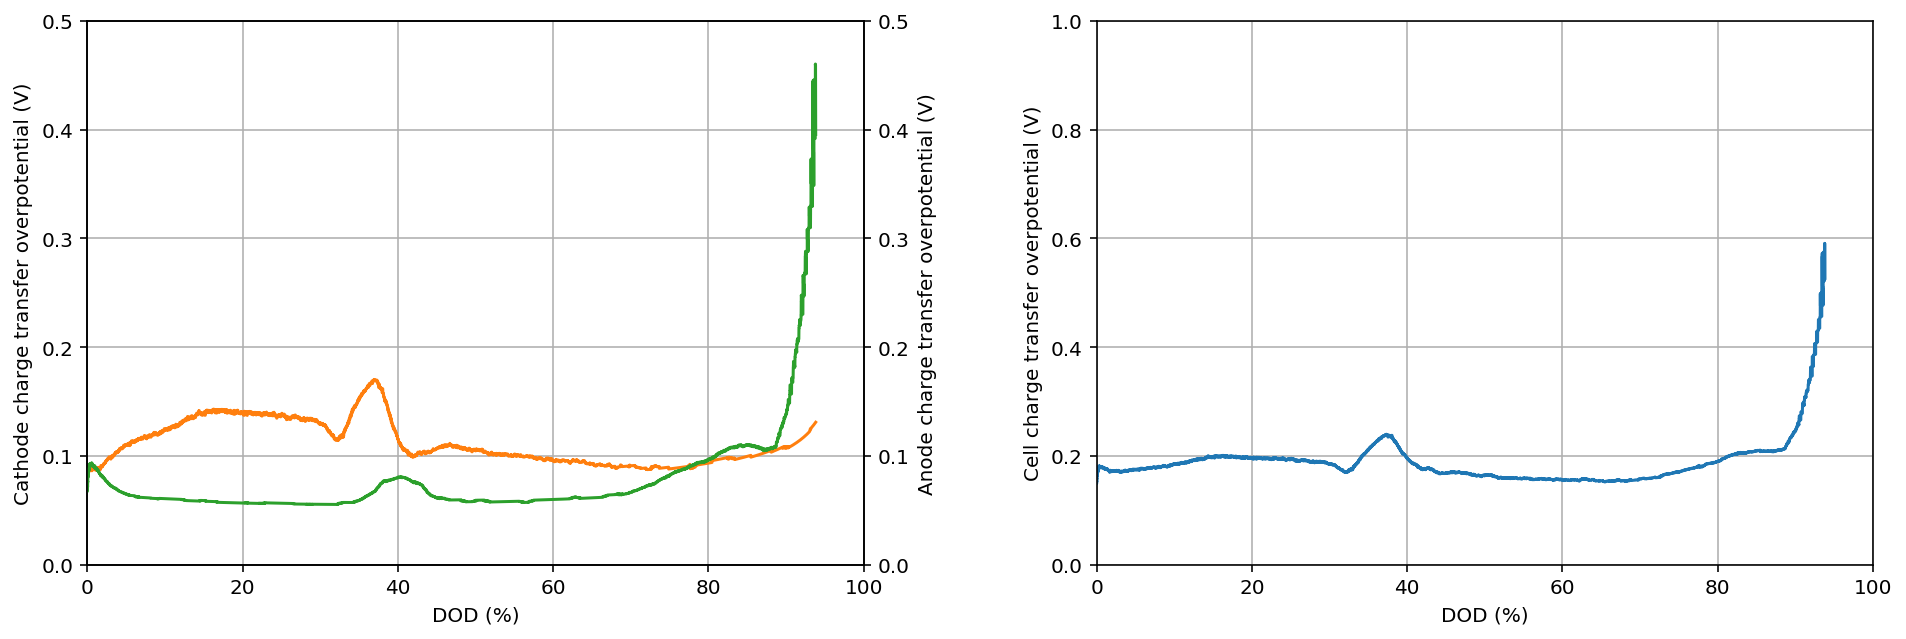

In [37]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.3)
ax2 = ax1.twinx()
ax1.plot(df_sim['DOD (%)'], (df_sim['Cathode OCV (V)'] - df_sim['Cathode CCV (V)']), color = new_colors[1])
ax1.set_ylabel('Cathode charge transfer overpotential (V)')
ax2.plot(df_sim['DOD (%)'], (df_sim['Anode CCV (V)'] - df_sim['Anode OCV (V)']), color = new_colors[2])
ax2.set_ylabel('Anode charge transfer overpotential (V)')
ax1.set_xlabel('DOD (%)')
ax1.set_ylim([0, 0.5])
ax2.set_ylim([0, 0.5])
ax1.set_xlim([0, 100])
ax1.grid()

ax3.plot(df_sim['DOD (%)'], (df_sim['Cell OCV (V)'] - df_sim['Cell CCV (V)']), color = new_colors[0])
ax3.set_ylabel('Cell charge transfer overpotential (V)')
ax3.set_xlabel('DOD (%)')
ax3.set_ylim([0, 1.0])
ax3.set_xlim([0, 100])
ax3.grid()

plt.show()

## Appendix